In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/ANATOMIA PATOLOGICA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=141.7, x1=110.4, y1=152.7
Page 1, Q1, A: Yellow pixels: 948
Page 1, Q1, A: Total non-white pixels: 1116
Page 1, Q1, A: Yellow percentage: 84.9%


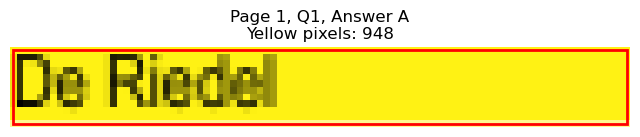

Page 1, Q1 - B: Detected box: x0=68.3, y0=154.3, x1=207.1, y1=165.3
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 692
Page 1, Q1, B: Yellow percentage: 0.0%


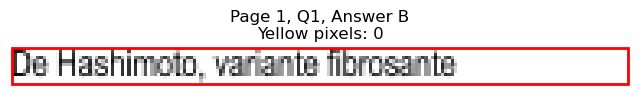

Page 1, Q1 - C: Detected box: x0=327.5, y0=141.7, x1=371.2, y1=152.7
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 222
Page 1, Q1, C: Yellow percentage: 0.0%


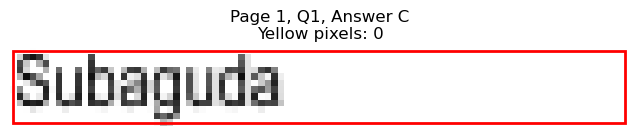

Page 1, Q1 - D: Detected box: x0=327.5, y0=154.3, x1=380.6, y1=165.3
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 256
Page 1, Q1, D: Yellow percentage: 0.0%


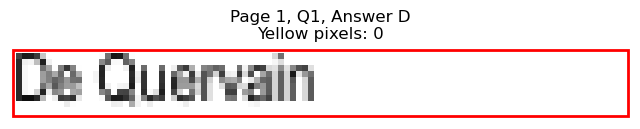


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=230.8, y1=203.1
Page 1, Q2, A: Yellow pixels: 213
Page 1, Q2, A: Total non-white pixels: 1236
Page 1, Q2, A: Yellow percentage: 17.2%


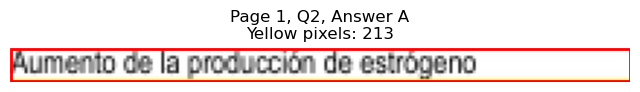

Page 1, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=217.8, y1=215.7
Page 1, Q2, B: Yellow pixels: 1820
Page 1, Q2, B: Total non-white pixels: 2400
Page 1, Q2, B: Yellow percentage: 75.8%


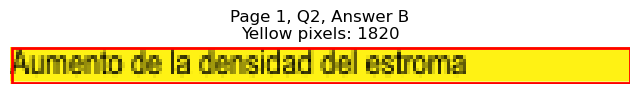

Page 1, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=513.5, y1=203.1
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 918
Page 1, Q2, C: Yellow percentage: 0.0%


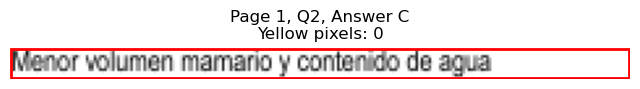

Page 1, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=504.0, y1=215.7
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 865
Page 1, Q2, D: Yellow percentage: 0.0%


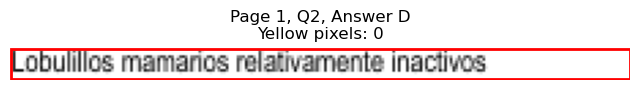


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=227.3, y1=253.6
Page 1, Q3, A: Yellow pixels: 1683
Page 1, Q3, A: Total non-white pixels: 2520
Page 1, Q3, A: Yellow percentage: 66.8%


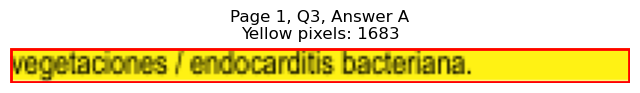

Page 1, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=203.6, y1=266.2
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 705
Page 1, Q3, B: Yellow percentage: 0.0%


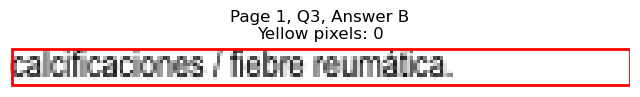

Page 1, Q3 - C: Detected box: x0=327.5, y0=242.6, x1=513.1, y1=253.6
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 948
Page 1, Q3, C: Yellow percentage: 0.0%


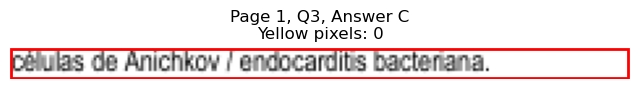

Page 1, Q3 - D: Detected box: x0=327.5, y0=255.2, x1=457.9, y1=266.2
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 665
Page 1, Q3, D: Yellow percentage: 0.0%


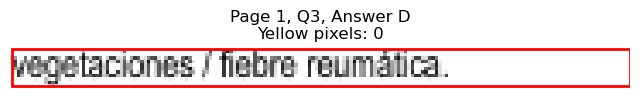


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=305.7, x1=137.0, y1=316.8
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 372
Page 1, Q4, A: Yellow percentage: 0.0%


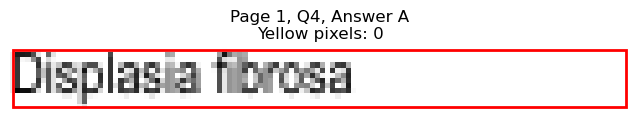

Page 1, Q4 - B: Detected box: x0=68.3, y0=318.3, x1=172.1, y1=329.4
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 510
Page 1, Q4, B: Yellow percentage: 0.0%


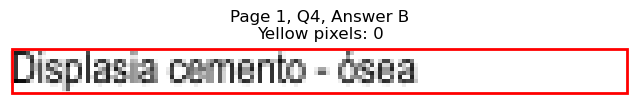

Page 1, Q4 - C: Detected box: x0=327.5, y0=305.7, x1=465.4, y1=316.8
Page 1, Q4, C: Yellow pixels: 189
Page 1, Q4, C: Total non-white pixels: 918
Page 1, Q4, C: Yellow percentage: 20.6%


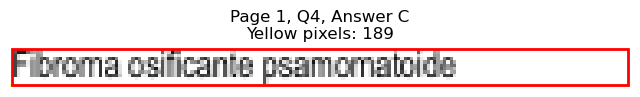

Page 1, Q4 - D: Detected box: x0=327.5, y0=318.3, x1=403.8, y1=329.4
Page 1, Q4, D: Yellow pixels: 1094
Page 1, Q4, D: Total non-white pixels: 1524
Page 1, Q4, D: Yellow percentage: 71.8%


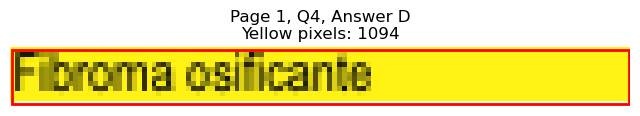


Page 1, Q4 - Selected Answer: D (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=164.6, y1=405.1
Page 1, Q5, A: Yellow pixels: 1212
Page 1, Q5, A: Total non-white pixels: 1621
Page 1, Q5, A: Yellow percentage: 74.8%


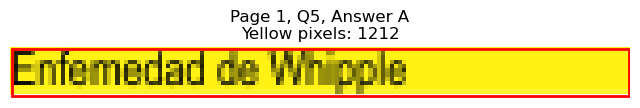

Page 1, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=131.5, y1=417.7
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 339
Page 1, Q5, B: Yellow percentage: 0.0%


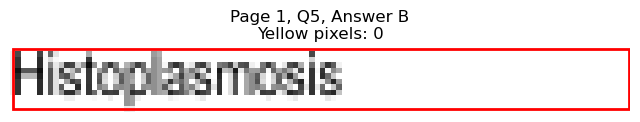

Page 1, Q5 - C: Detected box: x0=327.5, y0=394.0, x1=471.4, y1=405.1
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 735
Page 1, Q5, C: Yellow percentage: 0.0%


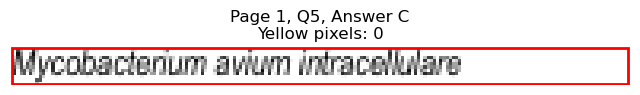

Page 1, Q5 - D: Detected box: x0=327.5, y0=406.6, x1=405.7, y1=417.7
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 422
Page 1, Q5, D: Yellow percentage: 0.0%


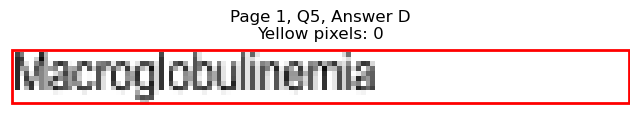


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=444.6, x1=211.2, y1=455.6
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 728
Page 1, Q6, A: Yellow percentage: 0.0%


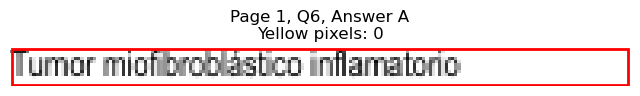

Page 1, Q6 - B: Detected box: x0=68.3, y0=457.2, x1=152.0, y1=468.2
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 426
Page 1, Q6, B: Yellow percentage: 0.0%


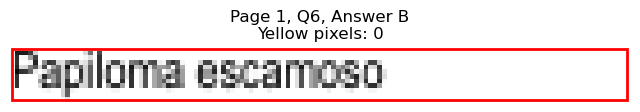

Page 1, Q6 - C: Detected box: x0=327.5, y0=444.6, x1=399.7, y1=455.6
Page 1, Q6, C: Yellow pixels: 123
Page 1, Q6, C: Total non-white pixels: 475
Page 1, Q6, C: Yellow percentage: 25.9%


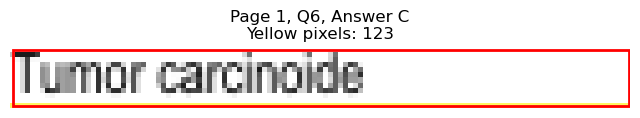

Page 1, Q6 - D: Detected box: x0=327.5, y0=457.2, x1=390.7, y1=468.2
Page 1, Q6, D: Yellow pixels: 1024
Page 1, Q6, D: Total non-white pixels: 1259
Page 1, Q6, D: Yellow percentage: 81.3%


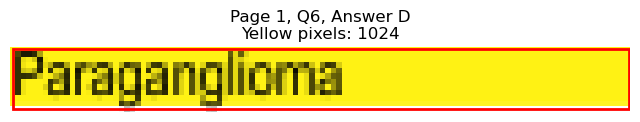


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=495.1, x1=362.6, y1=506.1
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 1438
Page 1, Q7, A: Yellow percentage: 0.0%


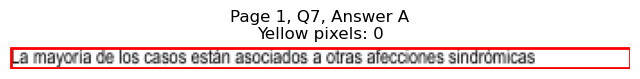

Page 1, Q7 - B: Detected box: x0=68.3, y0=507.7, x1=406.3, y1=518.7
Page 1, Q7, B: Yellow pixels: 389
Page 1, Q7, B: Total non-white pixels: 1992
Page 1, Q7, B: Yellow percentage: 19.5%


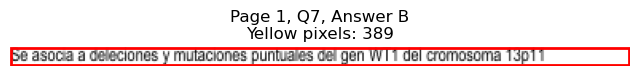

Page 1, Q7 - C: Detected box: x0=68.8, y0=520.3, x1=240.2, y1=531.3
Page 1, Q7, C: Yellow pixels: 1777
Page 1, Q7, C: Total non-white pixels: 2676
Page 1, Q7, C: Yellow percentage: 66.4%


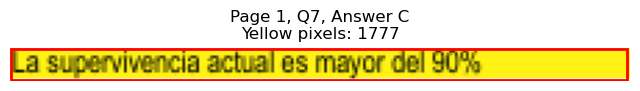

Page 1, Q7 - D: Detected box: x0=68.8, y0=532.9, x1=439.8, y1=543.9
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 1842
Page 1, Q7, D: Yellow percentage: 0.0%


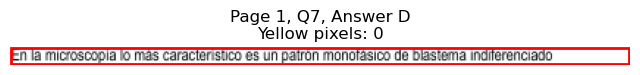


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=583.4, x1=144.5, y1=594.4
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 403
Page 1, Q8, A: Yellow percentage: 0.0%


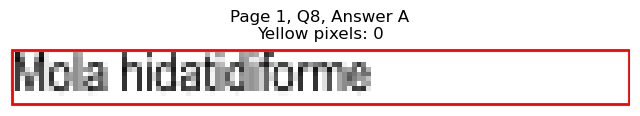

Page 1, Q8 - B: Detected box: x0=68.3, y0=596.0, x1=125.4, y1=607.0
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 279
Page 1, Q8, B: Yellow percentage: 0.0%


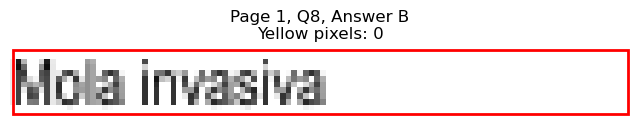

Page 1, Q8 - C: Detected box: x0=327.5, y0=583.4, x1=492.5, y1=594.4
Page 1, Q8, C: Yellow pixels: 1699
Page 1, Q8, C: Total non-white pixels: 2556
Page 1, Q8, C: Yellow percentage: 66.5%


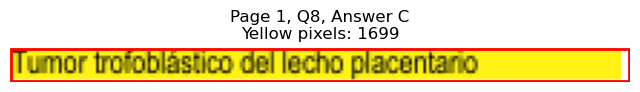

Page 1, Q8 - D: Detected box: x0=327.5, y0=596.0, x1=393.1, y1=607.0
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 333
Page 1, Q8, D: Yellow percentage: 0.0%


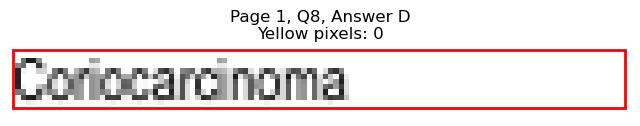


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=659.1, x1=189.1, y1=670.2
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 622
Page 1, Q9, A: Yellow percentage: 0.0%


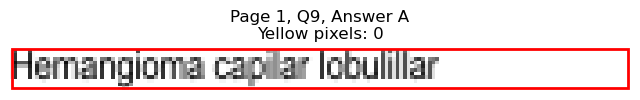

Page 1, Q9 - B: Detected box: x0=68.3, y0=671.7, x1=145.0, y1=682.8
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 398
Page 1, Q9, B: Yellow percentage: 0.0%


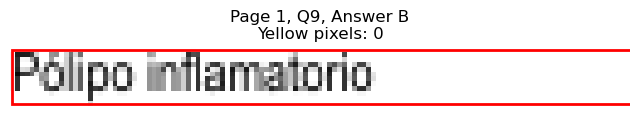

Page 1, Q9 - C: Detected box: x0=327.5, y0=659.1, x1=438.4, y1=670.2
Page 1, Q9, C: Yellow pixels: 1363
Page 1, Q9, C: Total non-white pixels: 1787
Page 1, Q9, C: Yellow percentage: 76.3%


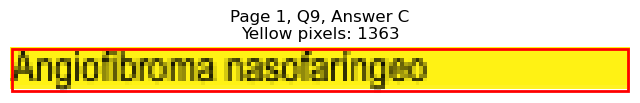

Page 1, Q9 - D: Detected box: x0=327.5, y0=671.7, x1=404.8, y1=682.8
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 376
Page 1, Q9, D: Yellow percentage: 0.0%


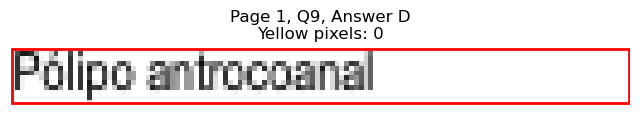


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=734.8, x1=95.4, y1=745.9
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 138
Page 1, Q10, A: Yellow percentage: 0.0%


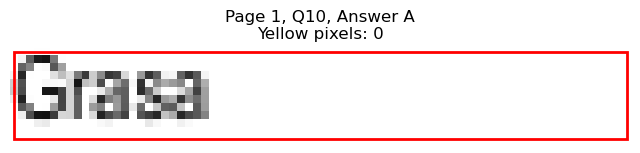

Page 1, Q10 - B: Detected box: x0=68.3, y0=747.4, x1=118.4, y1=758.5
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 270
Page 1, Q10, B: Yellow percentage: 0.0%


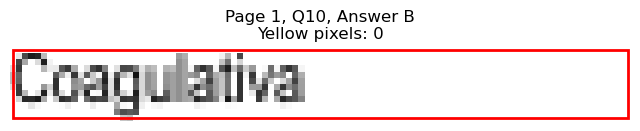

Page 1, Q10 - C: Detected box: x0=327.5, y0=734.8, x1=369.6, y1=745.9
Page 1, Q10, C: Yellow pixels: 921
Page 1, Q10, C: Total non-white pixels: 1116
Page 1, Q10, C: Yellow percentage: 82.5%


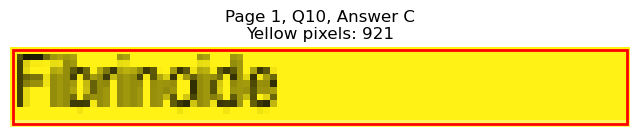

Page 1, Q10 - D: Detected box: x0=327.5, y0=747.4, x1=377.6, y1=758.5
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 238
Page 1, Q10, D: Yellow percentage: 0.0%


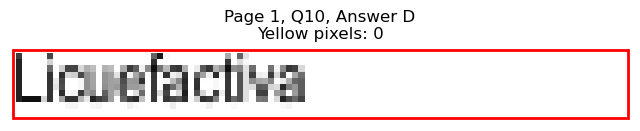


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=115.4, y1=140.0
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 248
Page 2, Q1, A: Yellow percentage: 0.0%


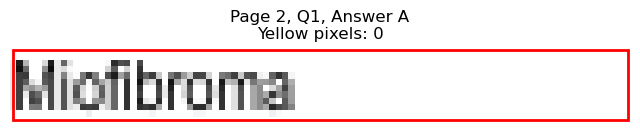

Page 2, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=135.0, y1=152.7
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 349
Page 2, Q1, B: Yellow percentage: 0.0%


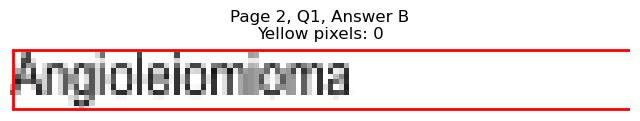

Page 2, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=386.2, y1=140.0
Page 2, Q1, C: Yellow pixels: 1063
Page 2, Q1, C: Total non-white pixels: 1320
Page 2, Q1, C: Yellow percentage: 80.5%


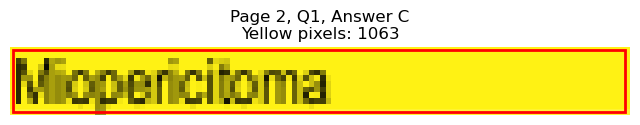

Page 2, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=389.6, y1=152.7
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 307
Page 2, Q1, D: Yellow percentage: 0.0%


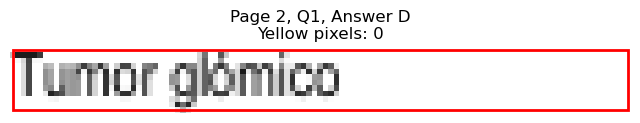


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=204.7, x1=109.9, y1=215.7
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 227
Page 2, Q2, A: Yellow percentage: 0.0%


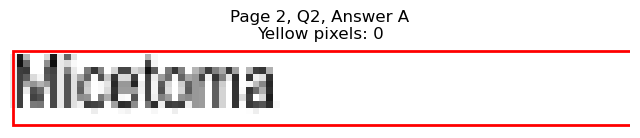

Page 2, Q2 - B: Detected box: x0=68.3, y0=217.4, x1=125.9, y1=228.4
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 310
Page 2, Q2, B: Yellow percentage: 0.0%


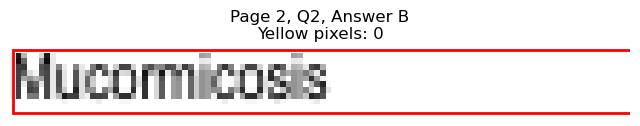

Page 2, Q2 - C: Detected box: x0=327.5, y0=204.7, x1=390.1, y1=215.7
Page 2, Q2, C: Yellow pixels: 1106
Page 2, Q2, C: Total non-white pixels: 1368
Page 2, Q2, C: Yellow percentage: 80.8%


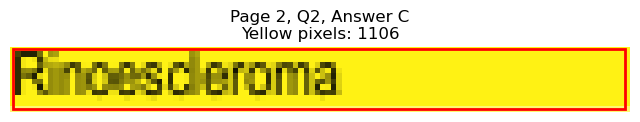

Page 2, Q2 - D: Detected box: x0=327.5, y0=217.4, x1=444.8, y1=228.4
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 589
Page 2, Q2, D: Yellow percentage: 0.0%


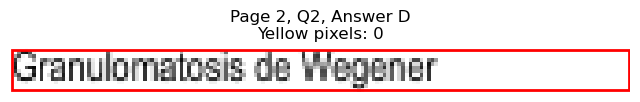


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=168.1, y1=266.2
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 498
Page 2, Q3, A: Yellow percentage: 0.0%


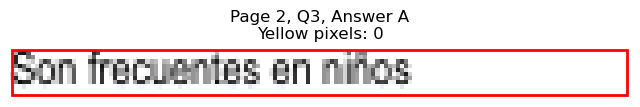

Page 2, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=296.0, y1=278.8
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 1131
Page 2, Q3, B: Yellow percentage: 0.0%


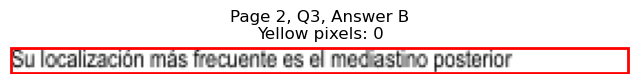

Page 2, Q3 - C: Detected box: x0=68.8, y0=280.5, x1=306.5, y1=291.6
Page 2, Q3, C: Yellow pixels: 289
Page 2, Q3, C: Total non-white pixels: 1458
Page 2, Q3, C: Yellow percentage: 19.8%


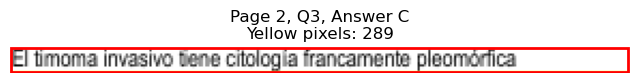

Page 2, Q3 - D: Detected box: x0=68.8, y0=293.1, x1=233.3, y1=304.2
Page 2, Q3, D: Yellow pixels: 1771
Page 2, Q3, D: Total non-white pixels: 2380
Page 2, Q3, D: Yellow percentage: 74.4%


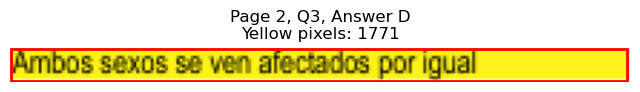


Page 2, Q3 - Selected Answer: D (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=368.8, x1=202.2, y1=379.9
Page 2, Q4, A: Yellow pixels: 1677
Page 2, Q4, A: Total non-white pixels: 2220
Page 2, Q4, A: Yellow percentage: 75.5%


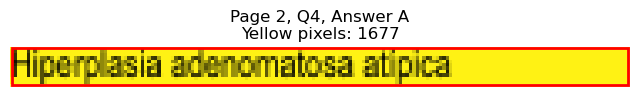

Page 2, Q4 - B: Detected box: x0=68.3, y0=381.4, x1=192.1, y1=392.5
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 682
Page 2, Q4, B: Yellow percentage: 0.0%


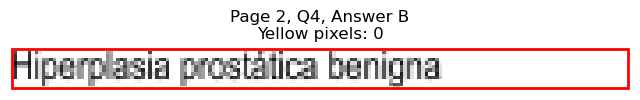

Page 2, Q4 - C: Detected box: x0=327.5, y0=368.8, x1=416.3, y1=379.9
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 485
Page 2, Q4, C: Yellow percentage: 0.0%


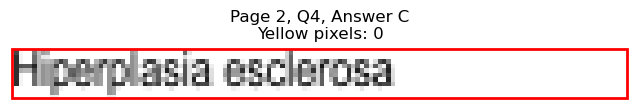

Page 2, Q4 - D: Detected box: x0=327.5, y0=381.4, x1=411.7, y1=392.5
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 422
Page 2, Q4, D: Yellow percentage: 0.0%


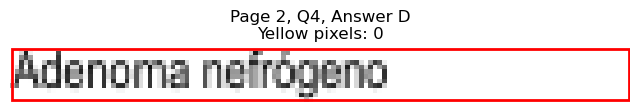


Page 2, Q4 - Selected Answer: A (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=419.4, x1=313.6, y1=430.4
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 1230
Page 2, Q5, A: Yellow percentage: 0.0%


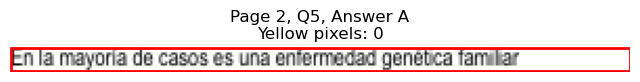

Page 2, Q5 - B: Detected box: x0=68.3, y0=432.0, x1=463.6, y1=443.0
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 1957
Page 2, Q5, B: Yellow percentage: 0.0%


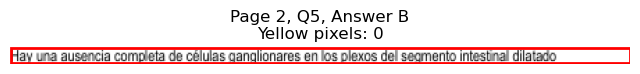

Page 2, Q5 - C: Detected box: x0=68.8, y0=444.6, x1=361.2, y1=455.6
Page 2, Q5, C: Yellow pixels: 344
Page 2, Q5, C: Total non-white pixels: 1778
Page 2, Q5, C: Yellow percentage: 19.3%


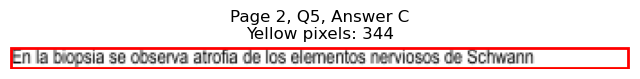

Page 2, Q5 - D: Detected box: x0=68.8, y0=457.2, x1=279.4, y1=468.2
Page 2, Q5, D: Yellow pixels: 2101
Page 2, Q5, D: Total non-white pixels: 2885
Page 2, Q5, D: Yellow percentage: 72.8%


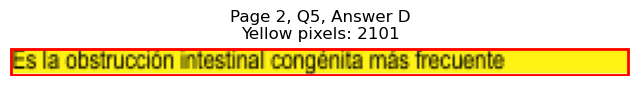


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=532.9, x1=152.5, y1=543.9
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 454
Page 2, Q6, A: Yellow percentage: 0.0%


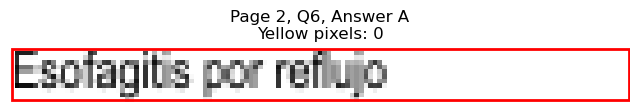

Page 2, Q6 - B: Detected box: x0=68.3, y0=545.5, x1=198.2, y1=556.5
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 692
Page 2, Q6, B: Yellow percentage: 0.0%


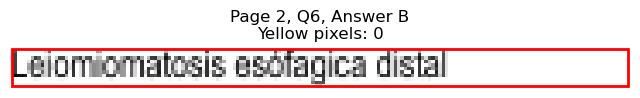

Page 2, Q6 - C: Detected box: x0=327.5, y0=532.9, x1=364.1, y1=543.9
Page 2, Q6, C: Yellow pixels: 906
Page 2, Q6, C: Total non-white pixels: 1056
Page 2, Q6, C: Yellow percentage: 85.8%


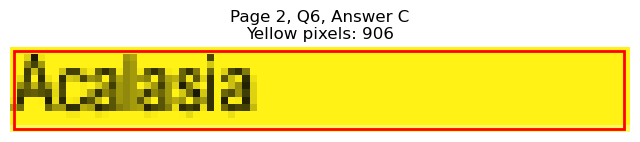

Page 2, Q6 - D: Detected box: x0=327.5, y0=545.5, x1=459.5, y1=556.5
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 691
Page 2, Q6, D: Yellow percentage: 0.0%


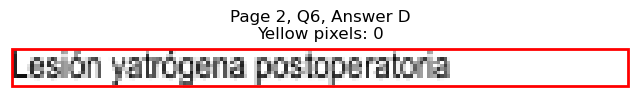


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=583.4, x1=251.9, y1=594.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 929
Page 2, Q7, A: Yellow percentage: 0.0%


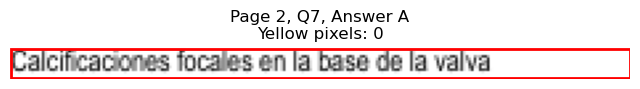

Page 2, Q7 - B: Detected box: x0=68.3, y0=596.0, x1=280.0, y1=607.0
Page 2, Q7, B: Yellow pixels: 262
Page 2, Q7, B: Total non-white pixels: 1547
Page 2, Q7, B: Yellow percentage: 16.9%


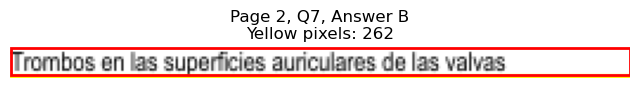

Page 2, Q7 - C: Detected box: x0=68.8, y0=608.6, x1=312.0, y1=619.6
Page 2, Q7, C: Yellow pixels: 2592
Page 2, Q7, C: Total non-white pixels: 3528
Page 2, Q7, C: Yellow percentage: 73.5%


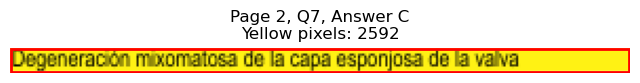

Page 2, Q7 - D: Detected box: x0=68.8, y0=621.3, x1=216.2, y1=632.4
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 742
Page 2, Q7, D: Yellow percentage: 0.0%


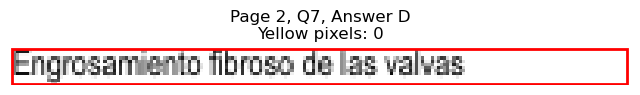


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=671.7, x1=110.9, y1=682.8
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 209
Page 2, Q8, A: Yellow percentage: 0.0%


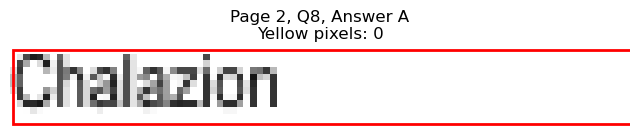

Page 2, Q8 - B: Detected box: x0=68.3, y0=684.3, x1=105.4, y1=695.4
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 212
Page 2, Q8, B: Yellow percentage: 0.0%


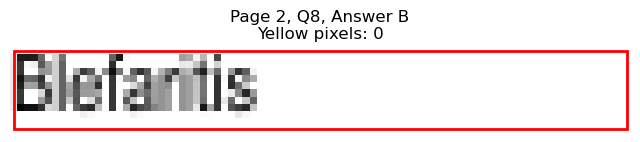

Page 2, Q8 - C: Detected box: x0=327.5, y0=671.7, x1=365.6, y1=682.8
Page 2, Q8, C: Yellow pixels: 905
Page 2, Q8, C: Total non-white pixels: 1068
Page 2, Q8, C: Yellow percentage: 84.7%


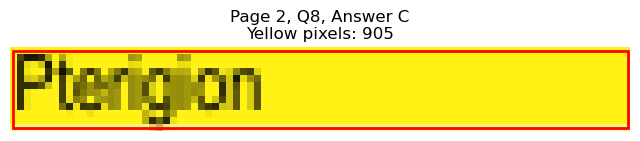

Page 2, Q8 - D: Detected box: x0=327.5, y0=684.3, x1=382.2, y1=695.4
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 272
Page 2, Q8, D: Yellow percentage: 0.0%


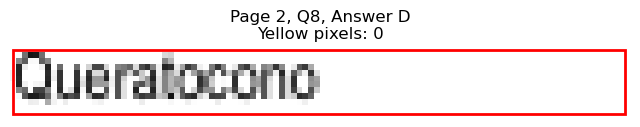


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=747.4, x1=164.5, y1=758.5
Page 2, Q9, A: Yellow pixels: 147
Page 2, Q9, A: Total non-white pixels: 616
Page 2, Q9, A: Yellow percentage: 23.9%


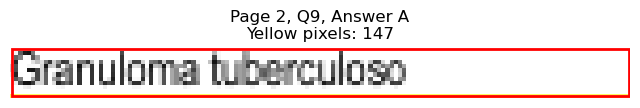

Page 2, Q9 - B: Detected box: x0=68.3, y0=760.2, x1=152.0, y1=771.2
Page 2, Q9, B: Yellow pixels: 1180
Page 2, Q9, B: Total non-white pixels: 1485
Page 2, Q9, B: Yellow percentage: 79.5%


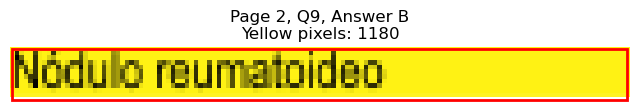

Page 2, Q9 - C: Detected box: x0=327.5, y0=747.4, x1=377.6, y1=758.5
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 243
Page 2, Q9, C: Yellow percentage: 0.0%


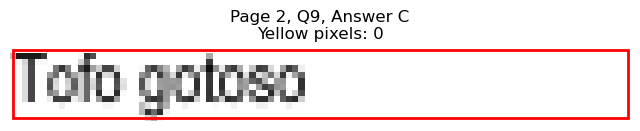

Page 2, Q9 - D: Detected box: x0=327.5, y0=760.2, x1=398.2, y1=771.2
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 394
Page 2, Q9, D: Yellow percentage: 0.0%


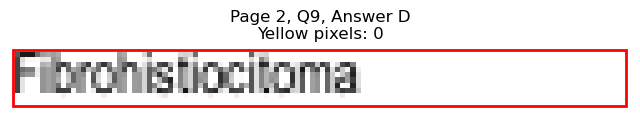


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=137.0, y1=102.2
Page 3, Q1, A: Yellow pixels: 1072
Page 3, Q1, A: Total non-white pixels: 1320
Page 3, Q1, A: Yellow percentage: 81.2%


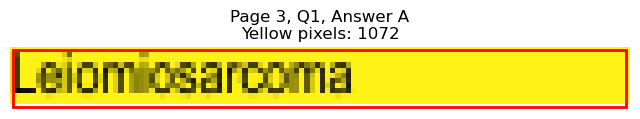

Page 3, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=206.2, y1=114.8
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 708
Page 3, Q1, B: Yellow percentage: 0.0%


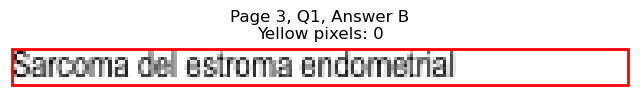

Page 3, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=424.8, y1=102.2
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 499
Page 3, Q1, C: Yellow percentage: 0.0%


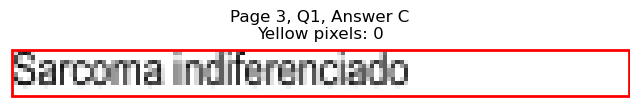

Page 3, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=395.6, y1=114.8
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 325
Page 3, Q1, D: Yellow percentage: 0.0%


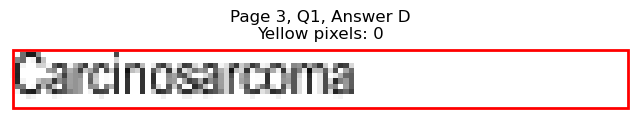


Page 3, Q1 - Selected Answer: A (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=148.6, y1=165.3
Page 3, Q2, A: Yellow pixels: 131
Page 3, Q2, A: Total non-white pixels: 570
Page 3, Q2, A: Yellow percentage: 23.0%


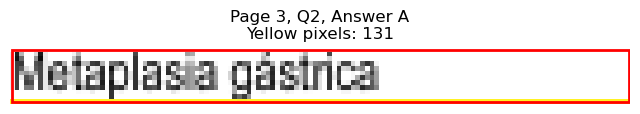

Page 3, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=151.6, y1=177.9
Page 3, Q2, B: Yellow pixels: 1260
Page 3, Q2, B: Total non-white pixels: 1608
Page 3, Q2, B: Yellow percentage: 78.4%


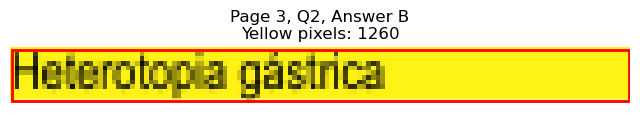

Page 3, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=462.8, y1=165.3
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 735
Page 3, Q2, C: Yellow percentage: 0.0%


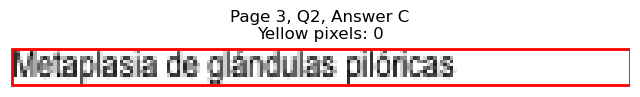

Page 3, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=366.6, y1=177.9
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 209
Page 3, Q2, D: Yellow percentage: 0.0%


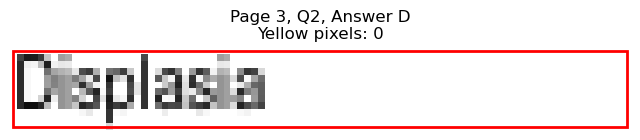


Page 3, Q2 - Selected Answer: B (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=143.0, y1=228.4
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 400
Page 3, Q3, A: Yellow percentage: 0.0%


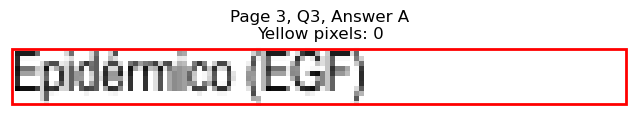

Page 3, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=168.1, y1=241.0
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 514
Page 3, Q3, B: Yellow percentage: 0.0%


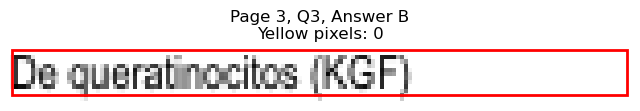

Page 3, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=467.9, y1=228.4
Page 3, Q3, C: Yellow pixels: 1568
Page 3, Q3, C: Total non-white pixels: 2292
Page 3, Q3, C: Yellow percentage: 68.4%


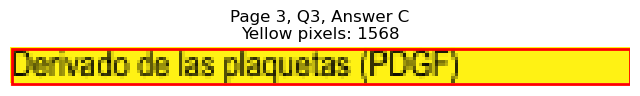

Page 3, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=443.8, y1=241.0
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 584
Page 3, Q3, D: Yellow percentage: 0.0%


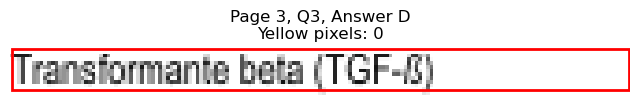


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=280.5, x1=125.4, y1=291.6
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 288
Page 3, Q4, A: Yellow percentage: 0.0%


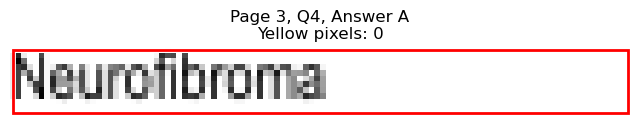

Page 3, Q4 - B: Detected box: x0=68.3, y0=293.1, x1=160.1, y1=304.2
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 431
Page 3, Q4, B: Yellow percentage: 0.0%


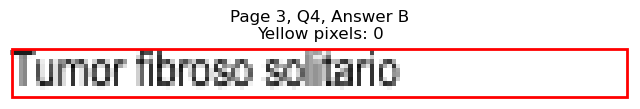

Page 3, Q4 - C: Detected box: x0=327.5, y0=280.5, x1=379.1, y1=291.6
Page 3, Q4, C: Yellow pixels: 103
Page 3, Q4, C: Total non-white pixels: 385
Page 3, Q4, C: Yellow percentage: 26.8%


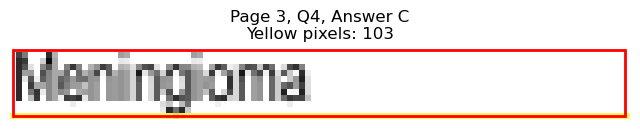

Page 3, Q4 - D: Detected box: x0=327.5, y0=293.1, x1=381.6, y1=304.2
Page 3, Q4, D: Yellow pixels: 971
Page 3, Q4, D: Total non-white pixels: 1155
Page 3, Q4, D: Yellow percentage: 84.1%


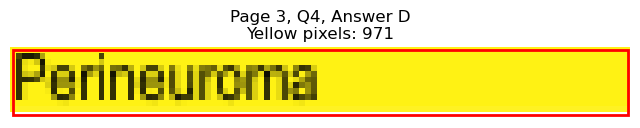


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=330.9, x1=116.9, y1=342.0
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 249
Page 3, Q5, A: Yellow percentage: 0.0%


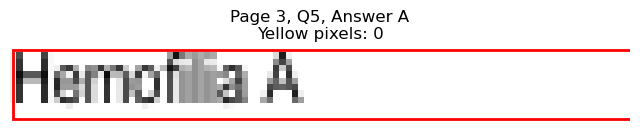

Page 3, Q5 - B: Detected box: x0=68.3, y0=343.6, x1=194.6, y1=354.7
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 647
Page 3, Q5, B: Yellow percentage: 0.0%


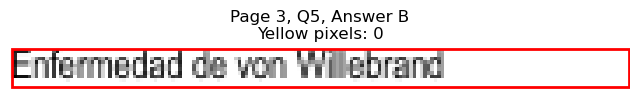

Page 3, Q5 - C: Detected box: x0=327.5, y0=330.9, x1=376.1, y1=342.0
Page 3, Q5, C: Yellow pixels: 987
Page 3, Q5, C: Total non-white pixels: 1200
Page 3, Q5, C: Yellow percentage: 82.2%


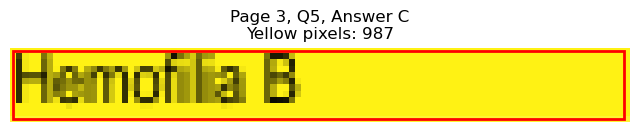

Page 3, Q5 - D: Detected box: x0=327.5, y0=343.6, x1=480.0, y1=354.7
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 751
Page 3, Q5, D: Yellow percentage: 0.0%


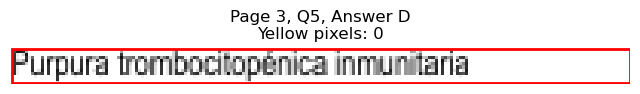


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=419.4, x1=125.4, y1=430.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 298
Page 3, Q6, A: Yellow percentage: 0.0%


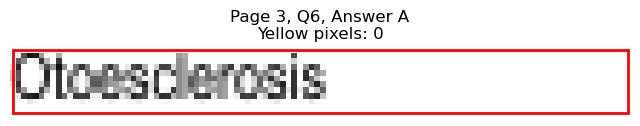

Page 3, Q6 - B: Detected box: x0=68.3, y0=432.0, x1=117.5, y1=443.0
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 251
Page 3, Q6, B: Yellow percentage: 0.0%


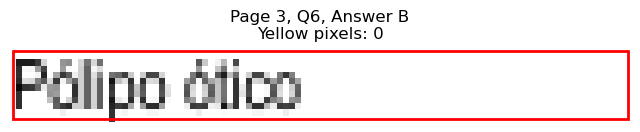

Page 3, Q6 - C: Detected box: x0=327.5, y0=419.4, x1=430.3, y1=430.4
Page 3, Q6, C: Yellow pixels: 154
Page 3, Q6, C: Total non-white pixels: 649
Page 3, Q6, C: Yellow percentage: 23.7%


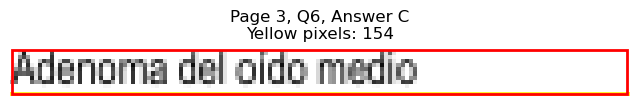

Page 3, Q6 - D: Detected box: x0=327.5, y0=432.0, x1=385.7, y1=443.0
Page 3, Q6, D: Yellow pixels: 1070
Page 3, Q6, D: Total non-white pixels: 1308
Page 3, Q6, D: Yellow percentage: 81.8%


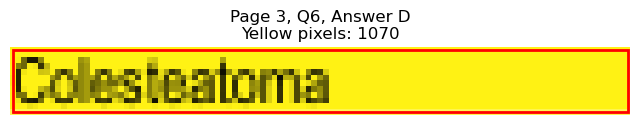


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=469.8, x1=164.5, y1=480.8
Page 3, Q7, A: Yellow pixels: 1374
Page 3, Q7, A: Total non-white pixels: 1764
Page 3, Q7, A: Yellow percentage: 77.9%


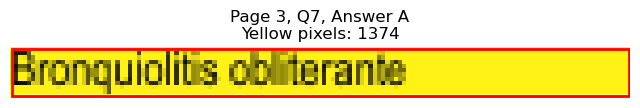

Page 3, Q7 - B: Detected box: x0=68.3, y0=482.5, x1=275.9, y1=493.5
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 1058
Page 3, Q7, B: Yellow percentage: 0.0%


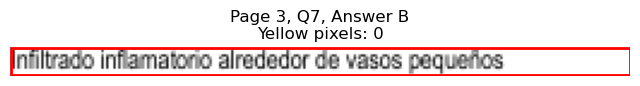

Page 3, Q7 - C: Detected box: x0=68.8, y0=495.1, x1=299.9, y1=506.1
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 1152
Page 3, Q7, C: Yellow percentage: 0.0%


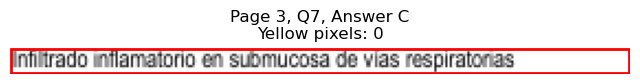

Page 3, Q7 - D: Detected box: x0=68.8, y0=507.7, x1=242.9, y1=518.7
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 872
Page 3, Q7, D: Yellow percentage: 0.0%


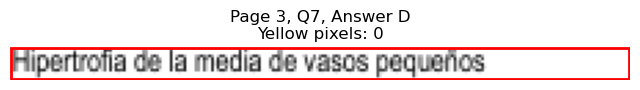


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=545.5, x1=142.6, y1=556.5
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 393
Page 3, Q8, A: Yellow percentage: 0.0%


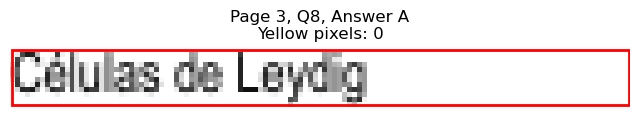

Page 3, Q8 - B: Detected box: x0=68.3, y0=558.2, x1=198.1, y1=569.2
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 662
Page 3, Q8, B: Yellow percentage: 0.0%


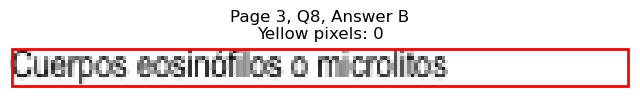

Page 3, Q8 - C: Detected box: x0=327.5, y0=545.5, x1=400.7, y1=556.5
Page 3, Q8, C: Yellow pixels: 1049
Page 3, Q8, C: Total non-white pixels: 1488
Page 3, Q8, C: Yellow percentage: 70.5%


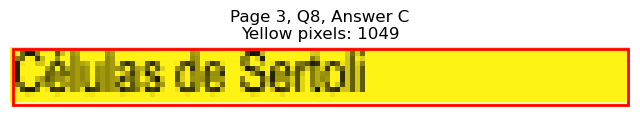

Page 3, Q8 - D: Detected box: x0=327.5, y0=558.2, x1=521.6, y1=569.2
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 1002
Page 3, Q8, D: Yellow percentage: 0.0%


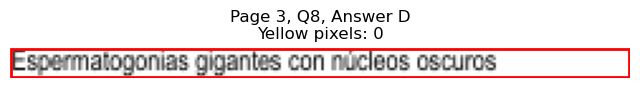


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=596.0, x1=109.4, y1=607.0
Page 3, Q9, A: Yellow pixels: 92
Page 3, Q9, A: Total non-white pixels: 396
Page 3, Q9, A: Yellow percentage: 23.2%


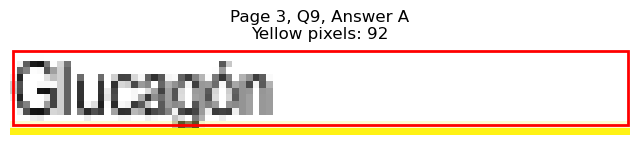

Page 3, Q9 - B: Detected box: x0=68.3, y0=608.6, x1=128.5, y1=619.6
Page 3, Q9, B: Yellow pixels: 1073
Page 3, Q9, B: Total non-white pixels: 1332
Page 3, Q9, B: Yellow percentage: 80.6%


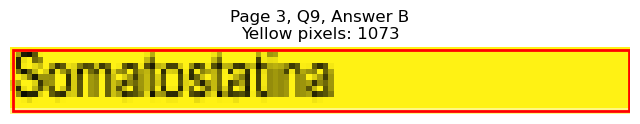

Page 3, Q9 - C: Detected box: x0=327.5, y0=596.0, x1=364.1, y1=607.0
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 175
Page 3, Q9, C: Yellow percentage: 0.0%


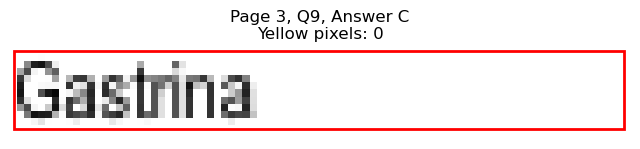

Page 3, Q9 - D: Detected box: x0=327.5, y0=608.6, x1=428.3, y1=619.6
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 545
Page 3, Q9, D: Yellow percentage: 0.0%


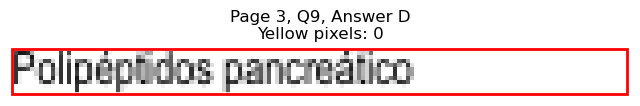


Page 3, Q9 - Selected Answer: B (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=671.7, x1=140.5, y1=682.8
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 390
Page 3, Q10, A: Yellow percentage: 0.0%


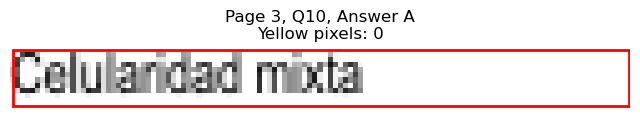

Page 3, Q10 - B: Detected box: x0=68.3, y0=684.3, x1=139.0, y1=695.4
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 331
Page 3, Q10, B: Yellow percentage: 0.0%


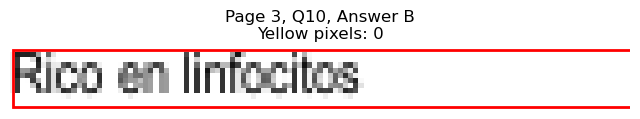

Page 3, Q10 - C: Detected box: x0=327.5, y0=671.7, x1=448.3, y1=682.8
Page 3, Q10, C: Yellow pixels: 172
Page 3, Q10, C: Total non-white pixels: 790
Page 3, Q10, C: Yellow percentage: 21.8%


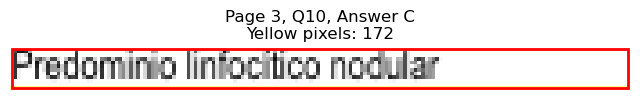

Page 3, Q10 - D: Detected box: x0=327.5, y0=684.3, x1=403.7, y1=695.4
Page 3, Q10, D: Yellow pixels: 1109
Page 3, Q10, D: Total non-white pixels: 1524
Page 3, Q10, D: Yellow percentage: 72.8%


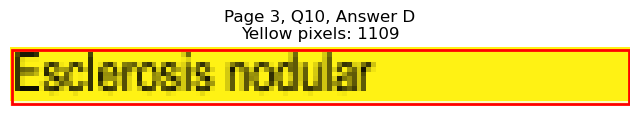


Page 3, Q10 - Selected Answer: D (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=143.0, y1=140.0
Page 4, Q1, A: Yellow pixels: 1262
Page 4, Q1, A: Total non-white pixels: 1512
Page 4, Q1, A: Yellow percentage: 83.5%


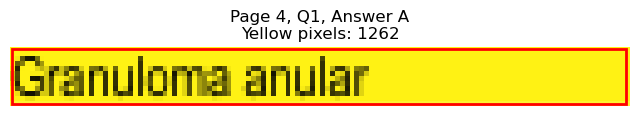

Page 4, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=164.5, y1=152.7
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 469
Page 4, Q1, B: Yellow percentage: 0.0%


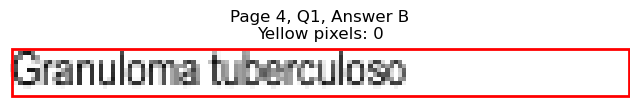

Page 4, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=444.8, y1=140.0
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 558
Page 4, Q1, C: Yellow percentage: 0.0%


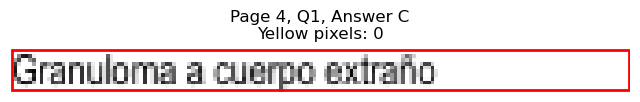

Page 4, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=462.5, y1=152.7
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 675
Page 4, Q1, D: Yellow percentage: 0.0%


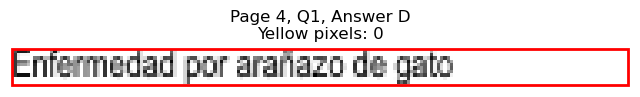


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=91.8, y1=203.1
Page 4, Q2, A: Yellow pixels: 723
Page 4, Q2, A: Total non-white pixels: 814
Page 4, Q2, A: Yellow percentage: 88.8%


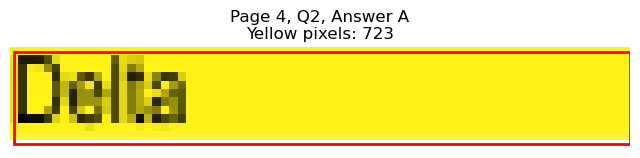

Page 4, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=86.4, y1=215.7
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 89
Page 4, Q2, B: Yellow percentage: 0.0%


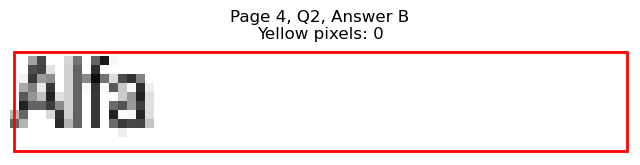

Page 4, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=348.6, y1=203.1
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 113
Page 4, Q2, C: Yellow percentage: 0.0%


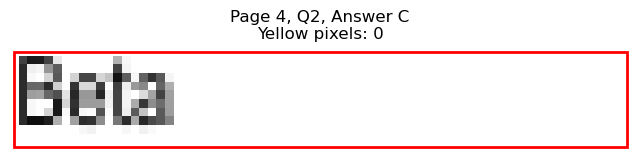

Page 4, Q2 - D: Detected box: x0=315.4, y0=204.7, x1=324.4, y1=215.7
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 69
Page 4, Q2, D: Yellow percentage: 0.0%


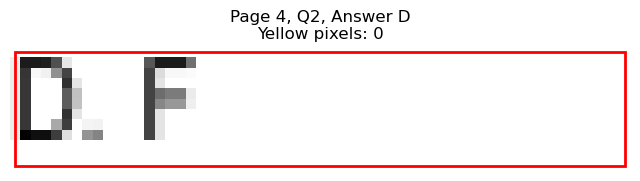


Page 4, Q2 - Selected Answer: A (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=186.6, y1=253.6
Page 4, Q3, A: Yellow pixels: 169
Page 4, Q3, A: Total non-white pixels: 741
Page 4, Q3, A: Yellow percentage: 22.8%


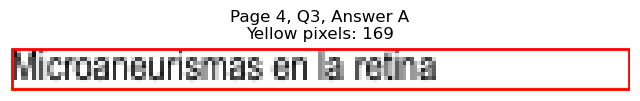

Page 4, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=334.6, y1=266.2
Page 4, Q3, B: Yellow pixels: 2440
Page 4, Q3, B: Total non-white pixels: 3494
Page 4, Q3, B: Yellow percentage: 69.8%


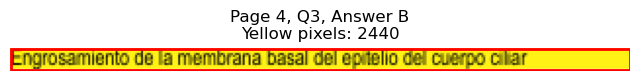

Page 4, Q3 - C: Detected box: x0=68.8, y0=267.8, x1=177.1, y1=278.8
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 553
Page 4, Q3, C: Yellow percentage: 0.0%


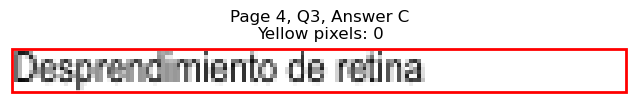

Page 4, Q3 - D: Detected box: x0=68.8, y0=280.5, x1=196.7, y1=291.6
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 668
Page 4, Q3, D: Yellow percentage: 0.0%


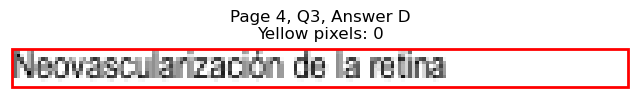


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=356.2, x1=136.4, y1=367.3
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 371
Page 4, Q4, A: Yellow percentage: 0.0%


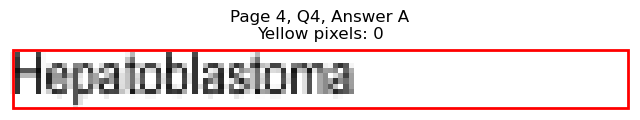

Page 4, Q4 - B: Detected box: x0=68.3, y0=368.8, x1=171.1, y1=379.9
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 498
Page 4, Q4, B: Yellow percentage: 0.0%


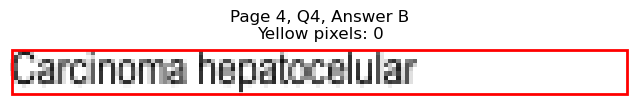

Page 4, Q4 - C: Detected box: x0=327.5, y0=356.2, x1=407.2, y1=367.3
Page 4, Q4, C: Yellow pixels: 131
Page 4, Q4, C: Total non-white pixels: 555
Page 4, Q4, C: Yellow percentage: 23.6%


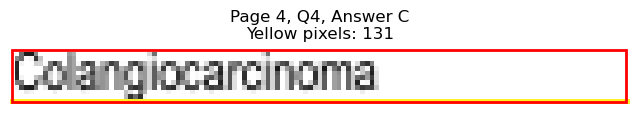

Page 4, Q4 - D: Detected box: x0=327.5, y0=368.8, x1=425.3, y1=379.9
Page 4, Q4, D: Yellow pixels: 1417
Page 4, Q4, D: Total non-white pixels: 1788
Page 4, Q4, D: Yellow percentage: 79.3%


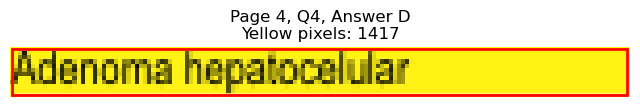


Page 4, Q4 - Selected Answer: D (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=274.4, y1=417.7
Page 4, Q5, A: Yellow pixels: 2344
Page 4, Q5, A: Total non-white pixels: 3084
Page 4, Q5, A: Yellow percentage: 76.0%


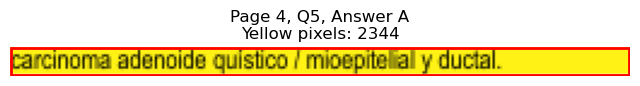

Page 4, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=318.0, y1=430.4
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 1200
Page 4, Q5, B: Yellow percentage: 0.0%


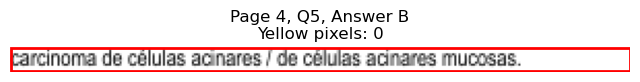

Page 4, Q5 - C: Detected box: x0=68.8, y0=432.0, x1=307.6, y1=443.0
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 1218
Page 4, Q5, C: Yellow percentage: 0.0%


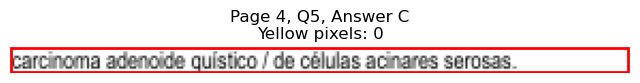

Page 4, Q5 - D: Detected box: x0=68.8, y0=444.6, x1=276.8, y1=455.6
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 1039
Page 4, Q5, D: Yellow percentage: 0.0%


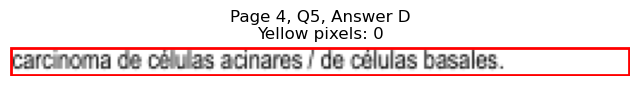


Page 4, Q5 - Selected Answer: A (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=216.2, y1=493.5
Page 4, Q6, A: Yellow pixels: 1639
Page 4, Q6, A: Total non-white pixels: 2388
Page 4, Q6, A: Yellow percentage: 68.6%


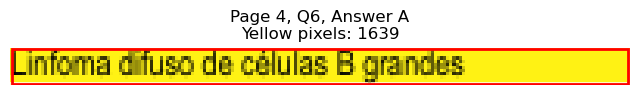

Page 4, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=193.7, y1=506.1
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 630
Page 4, Q6, B: Yellow percentage: 0.0%


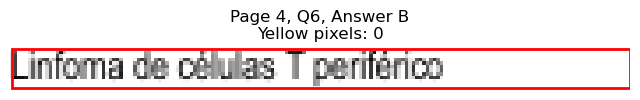

Page 4, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=410.3, y1=493.5
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 400
Page 4, Q6, C: Yellow percentage: 0.0%


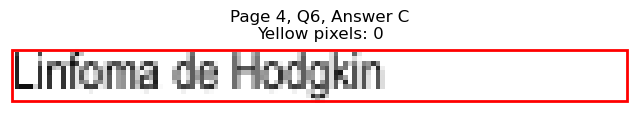

Page 4, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=395.6, y1=506.1
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 320
Page 4, Q6, D: Yellow percentage: 0.0%


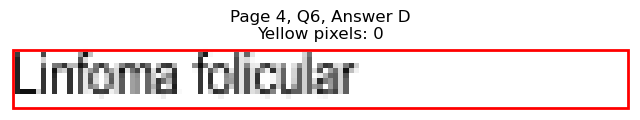


Page 4, Q6 - Selected Answer: A (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=558.2, x1=165.6, y1=569.2
Page 4, Q7, A: Yellow pixels: 148
Page 4, Q7, A: Total non-white pixels: 668
Page 4, Q7, A: Yellow percentage: 22.2%


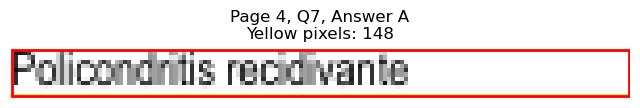

Page 4, Q7 - B: Detected box: x0=68.3, y0=570.8, x1=207.7, y1=581.8
Page 4, Q7, B: Yellow pixels: 1754
Page 4, Q7, B: Total non-white pixels: 2280
Page 4, Q7, B: Yellow percentage: 76.9%


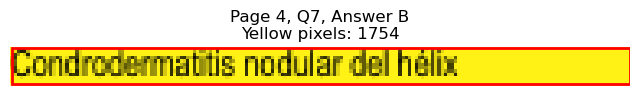

Page 4, Q7 - C: Detected box: x0=327.5, y0=558.2, x1=424.9, y1=569.2
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 489
Page 4, Q7, C: Yellow percentage: 0.0%


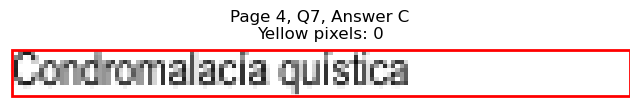

Page 4, Q7 - D: Detected box: x0=327.5, y0=570.8, x1=429.2, y1=581.8
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 512
Page 4, Q7, D: Yellow percentage: 0.0%


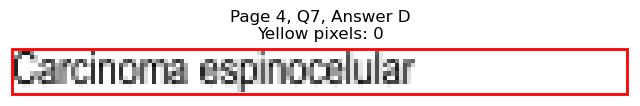


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=608.6, x1=268.9, y1=619.6
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 1027
Page 4, Q8, A: Yellow percentage: 0.0%


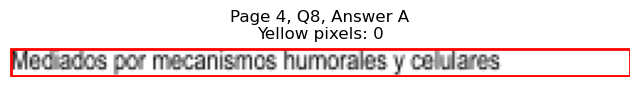

Page 4, Q8 - B: Detected box: x0=68.3, y0=621.3, x1=375.8, y1=632.4
Page 4, Q8, B: Yellow pixels: 358
Page 4, Q8, B: Total non-white pixels: 1918
Page 4, Q8, B: Yellow percentage: 18.7%


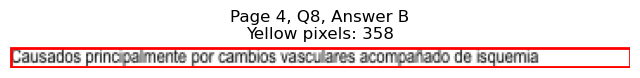

Page 4, Q8 - C: Detected box: x0=68.8, y0=633.9, x1=428.3, y1=645.0
Page 4, Q8, C: Yellow pixels: 3582
Page 4, Q8, C: Total non-white pixels: 4932
Page 4, Q8, C: Yellow percentage: 72.6%


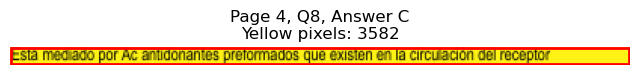

Page 4, Q8 - D: Detected box: x0=68.8, y0=646.5, x1=413.8, y1=657.6
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 1690
Page 4, Q8, D: Yellow percentage: 0.0%


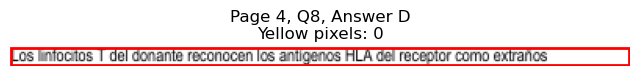


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=697.0, x1=188.2, y1=708.1
Page 4, Q9, A: Yellow pixels: 171
Page 4, Q9, A: Total non-white pixels: 973
Page 4, Q9, A: Yellow percentage: 17.6%


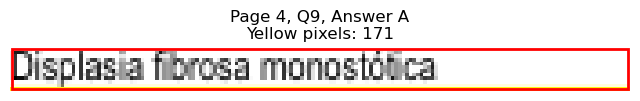

Page 4, Q9 - B: Detected box: x0=68.3, y0=709.6, x1=170.0, y1=720.7
Page 4, Q9, B: Yellow pixels: 1452
Page 4, Q9, B: Total non-white pixels: 1836
Page 4, Q9, B: Yellow percentage: 79.1%


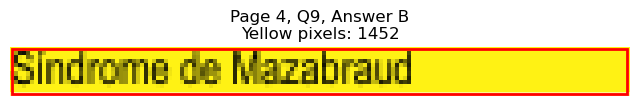

Page 4, Q9 - C: Detected box: x0=327.5, y0=697.0, x1=443.9, y1=708.1
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 633
Page 4, Q9, C: Yellow percentage: 0.0%


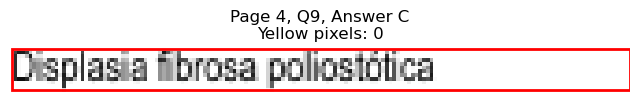

Page 4, Q9 - D: Detected box: x0=327.5, y0=709.6, x1=448.9, y1=720.7
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 642
Page 4, Q9, D: Yellow percentage: 0.0%


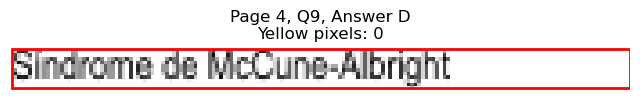


Page 4, Q9 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=139.6, y1=114.8
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 376
Page 5, Q1, A: Yellow percentage: 0.0%


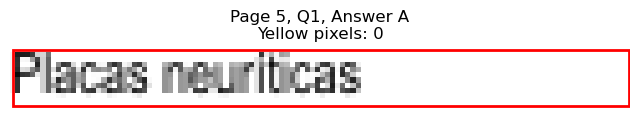

Page 5, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=157.6, y1=127.4
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 450
Page 5, Q1, B: Yellow percentage: 0.0%


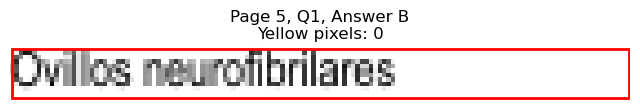

Page 5, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=409.2, y1=114.8
Page 5, Q1, C: Yellow pixels: 1288
Page 5, Q1, C: Total non-white pixels: 1596
Page 5, Q1, C: Yellow percentage: 80.7%


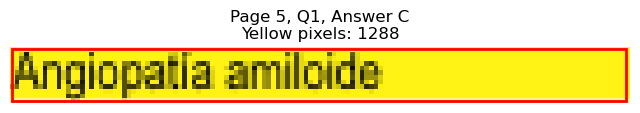

Page 5, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=387.1, y1=127.4
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 304
Page 5, Q1, D: Yellow percentage: 0.0%


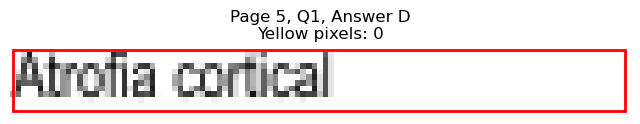


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=198.1, y1=203.1
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 642
Page 5, Q2, A: Yellow percentage: 0.0%


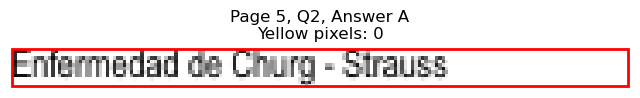

Page 5, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=217.3, y1=215.7
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 728
Page 5, Q2, B: Yellow percentage: 0.0%


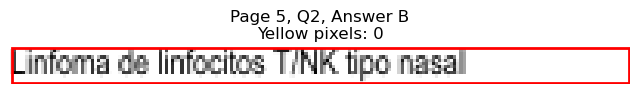

Page 5, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=444.8, y1=203.1
Page 5, Q2, C: Yellow pixels: 1413
Page 5, Q2, C: Total non-white pixels: 1851
Page 5, Q2, C: Yellow percentage: 76.3%


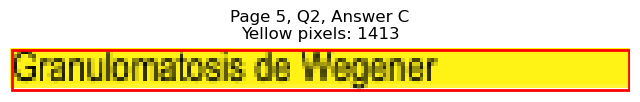

Page 5, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=482.5, y1=215.7
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 748
Page 5, Q2, D: Yellow percentage: 0.0%


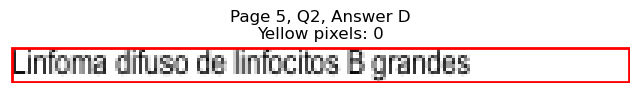


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=117.5, y1=278.8
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 271
Page 5, Q3, A: Yellow percentage: 0.0%


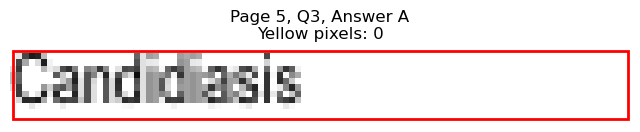

Page 5, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=131.5, y1=291.6
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 339
Page 5, Q3, B: Yellow percentage: 0.0%


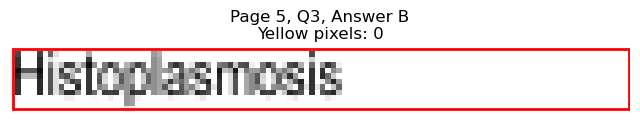

Page 5, Q3 - C: Detected box: x0=327.5, y0=267.8, x1=423.7, y1=278.8
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 659
Page 5, Q3, C: Yellow percentage: 0.0%


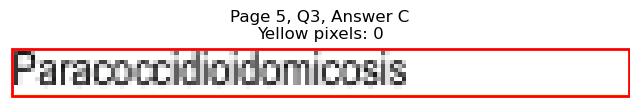

Page 5, Q3 - D: Detected box: x0=327.5, y0=280.5, x1=384.1, y1=291.6
Page 5, Q3, D: Yellow pixels: 959
Page 5, Q3, D: Total non-white pixels: 1296
Page 5, Q3, D: Yellow percentage: 74.0%


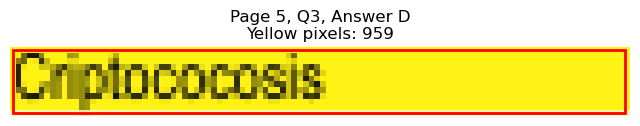


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=129.0, y1=342.0
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 425
Page 5, Q4, A: Yellow percentage: 0.0%


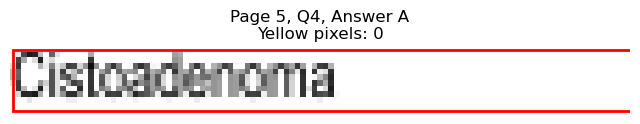

Page 5, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=143.0, y1=354.7
Page 5, Q4, B: Yellow pixels: 1239
Page 5, Q4, B: Total non-white pixels: 1512
Page 5, Q4, B: Yellow percentage: 81.9%


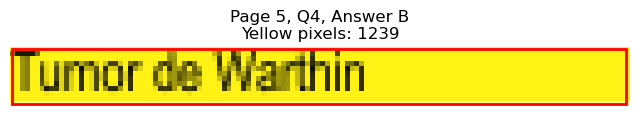

Page 5, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=514.6, y1=342.0
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 962
Page 5, Q4, C: Yellow percentage: 0.0%


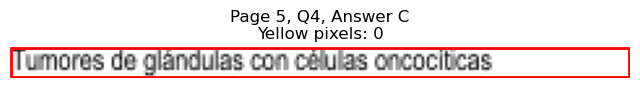

Page 5, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=423.8, y1=354.7
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 478
Page 5, Q4, D: Yellow percentage: 0.0%


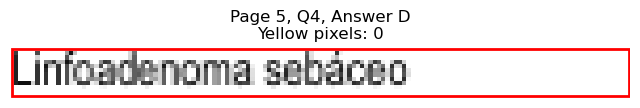


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=107.4, y1=392.5
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 207
Page 5, Q5, A: Yellow percentage: 0.0%


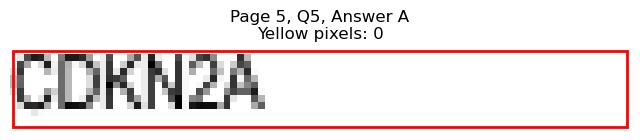

Page 5, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=101.9, y1=405.1
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 184
Page 5, Q5, B: Yellow percentage: 0.0%


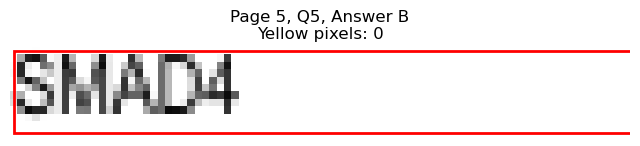

Page 5, Q5 - C: Detected box: x0=327.5, y0=381.4, x1=354.6, y1=392.5
Page 5, Q5, C: Yellow pixels: 750
Page 5, Q5, C: Total non-white pixels: 936
Page 5, Q5, C: Yellow percentage: 80.1%


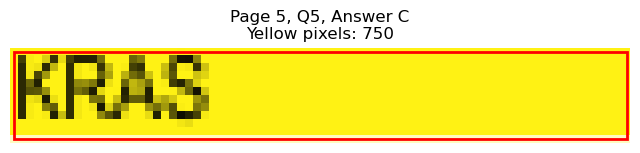

Page 5, Q5 - D: Detected box: x0=327.5, y0=394.0, x1=351.6, y1=405.1
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 122
Page 5, Q5, D: Yellow percentage: 0.0%


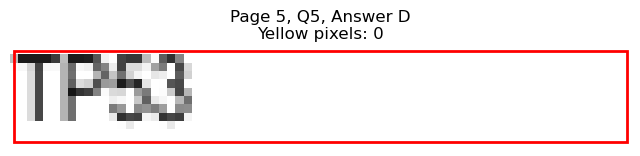


Page 5, Q5 - Selected Answer: C (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=469.8, x1=124.9, y1=480.8
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 281
Page 5, Q6, A: Yellow percentage: 0.0%


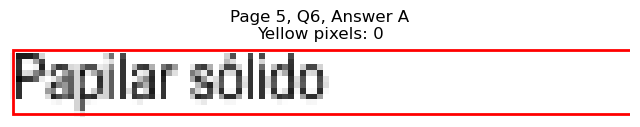

Page 5, Q6 - B: Detected box: x0=68.3, y0=482.5, x1=171.6, y1=493.5
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 501
Page 5, Q6, B: Yellow percentage: 0.0%


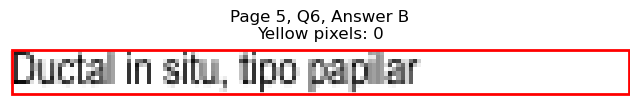

Page 5, Q6 - C: Detected box: x0=327.5, y0=469.8, x1=381.6, y1=480.8
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 372
Page 5, Q6, C: Yellow percentage: 0.0%


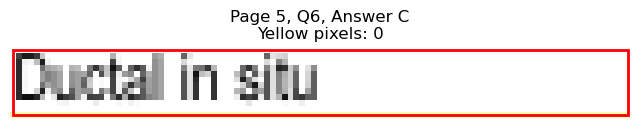

Page 5, Q6 - D: Detected box: x0=327.5, y0=482.5, x1=411.7, y1=493.5
Page 5, Q6, D: Yellow pixels: 1155
Page 5, Q6, D: Total non-white pixels: 1620
Page 5, Q6, D: Yellow percentage: 71.3%


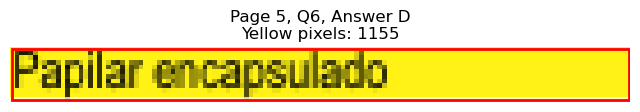


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=520.3, x1=115.4, y1=531.3
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 247
Page 5, Q7, A: Yellow percentage: 0.0%


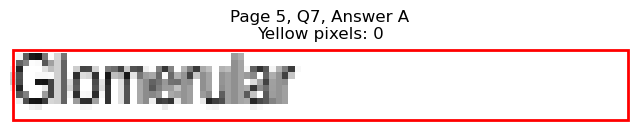

Page 5, Q7 - B: Detected box: x0=68.3, y0=532.9, x1=112.0, y1=543.9
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 198
Page 5, Q7, B: Yellow percentage: 0.0%


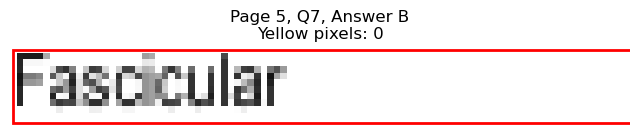

Page 5, Q7 - C: Detected box: x0=327.5, y0=520.3, x1=362.6, y1=531.3
Page 5, Q7, C: Yellow pixels: 786
Page 5, Q7, C: Total non-white pixels: 1032
Page 5, Q7, C: Yellow percentage: 76.2%


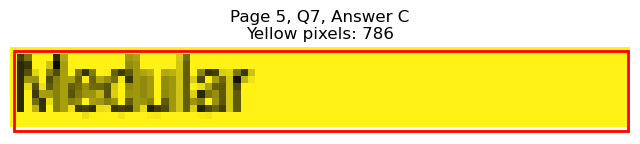

Page 5, Q7 - D: Detected box: x0=327.5, y0=532.9, x1=365.6, y1=543.9
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 204
Page 5, Q7, D: Yellow percentage: 0.0%


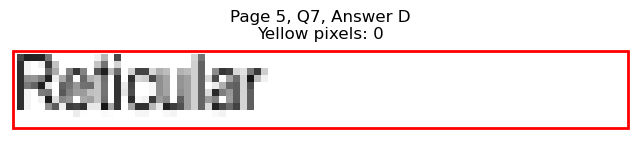


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=596.0, x1=184.1, y1=607.0
Page 5, Q8, A: Yellow pixels: 167
Page 5, Q8, A: Total non-white pixels: 907
Page 5, Q8, A: Yellow percentage: 18.4%


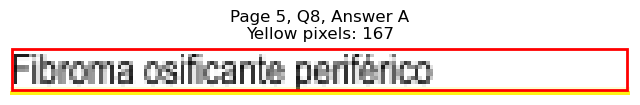

Page 5, Q8 - B: Detected box: x0=68.3, y0=608.6, x1=234.8, y1=619.6
Page 5, Q8, B: Yellow pixels: 1897
Page 5, Q8, B: Total non-white pixels: 2568
Page 5, Q8, B: Yellow percentage: 73.9%


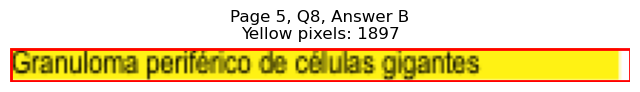

Page 5, Q8 - C: Detected box: x0=327.5, y0=596.0, x1=409.2, y1=607.0
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 408
Page 5, Q8, C: Yellow percentage: 0.0%


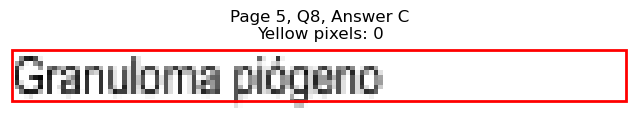

Page 5, Q8 - D: Detected box: x0=327.5, y0=608.6, x1=393.1, y1=619.6
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 357
Page 5, Q8, D: Yellow percentage: 0.0%


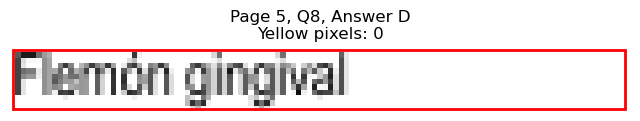


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=646.5, x1=140.0, y1=657.6
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 375
Page 5, Q9, A: Yellow percentage: 0.0%


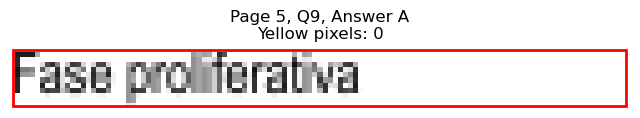

Page 5, Q9 - B: Detected box: x0=68.3, y0=659.1, x1=156.6, y1=670.2
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 433
Page 5, Q9, B: Yellow percentage: 0.0%


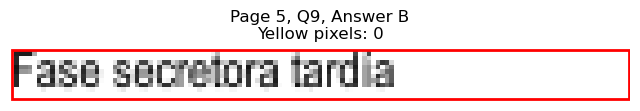

Page 5, Q9 - C: Detected box: x0=327.5, y0=646.5, x1=500.0, y1=657.6
Page 5, Q9, C: Yellow pixels: 213
Page 5, Q9, C: Total non-white pixels: 1128
Page 5, Q9, C: Yellow percentage: 18.9%


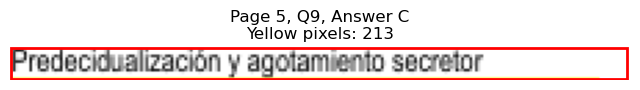

Page 5, Q9 - D: Detected box: x0=327.5, y0=659.1, x1=386.2, y1=670.2
Page 5, Q9, D: Yellow pixels: 988
Page 5, Q9, D: Total non-white pixels: 1210
Page 5, Q9, D: Yellow percentage: 81.7%


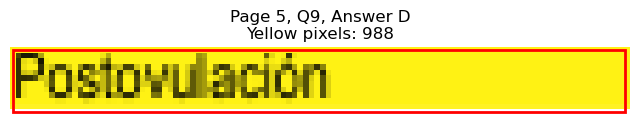


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=722.2, x1=133.0, y1=733.3
Page 5, Q10, A: Yellow pixels: 987
Page 5, Q10, A: Total non-white pixels: 1380
Page 5, Q10, A: Yellow percentage: 71.5%


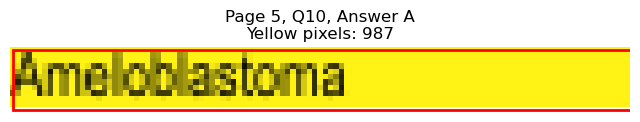

Page 5, Q10 - B: Detected box: x0=68.3, y0=734.8, x1=194.2, y1=745.9
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 665
Page 5, Q10, B: Yellow percentage: 0.0%


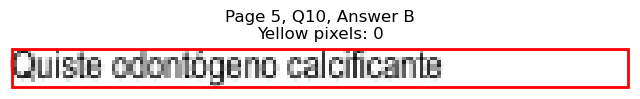

Page 5, Q10 - C: Detected box: x0=327.5, y0=722.2, x1=420.8, y1=733.3
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 488
Page 5, Q10, C: Yellow percentage: 0.0%


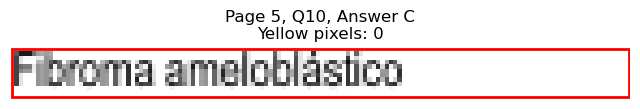

Page 5, Q10 - D: Detected box: x0=327.5, y0=734.8, x1=449.9, y1=745.9
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 597
Page 5, Q10, D: Yellow percentage: 0.0%


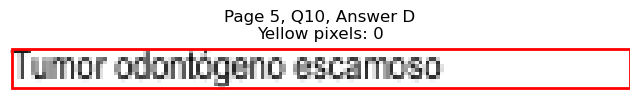


Page 5, Q10 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=140.5, y1=114.8
Page 6, Q1, A: Yellow pixels: 1177
Page 6, Q1, A: Total non-white pixels: 1476
Page 6, Q1, A: Yellow percentage: 79.7%


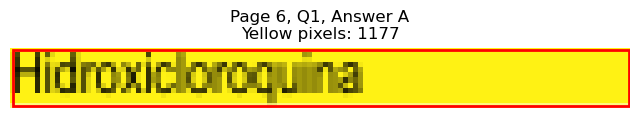

Page 6, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=107.9, y1=127.4
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 224
Page 6, Q1, B: Yellow percentage: 0.0%


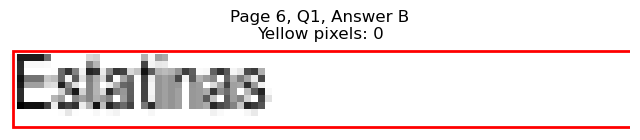

Page 6, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=395.2, y1=114.8
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 363
Page 6, Q1, C: Yellow percentage: 0.0%


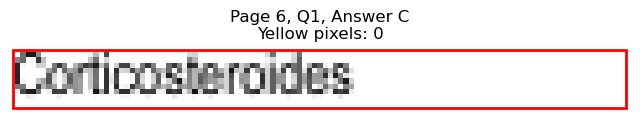

Page 6, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=458.3, y1=127.4
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 658
Page 6, Q1, D: Yellow percentage: 0.0%


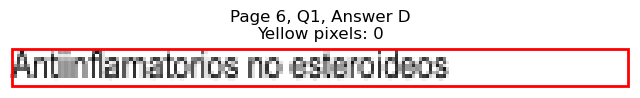


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=130.9, y1=165.3
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 323
Page 6, Q2, A: Yellow percentage: 0.0%


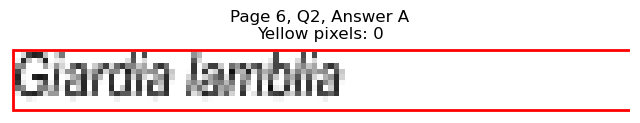

Page 6, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=169.1, y1=177.9
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 528
Page 6, Q2, B: Yellow percentage: 0.0%


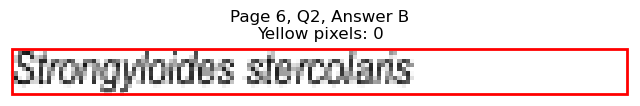

Page 6, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=418.3, y1=165.3
Page 6, Q2, C: Yellow pixels: 1185
Page 6, Q2, C: Total non-white pixels: 1704
Page 6, Q2, C: Yellow percentage: 69.5%


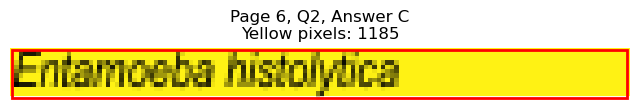

Page 6, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=393.1, y1=177.9
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 347
Page 6, Q2, D: Yellow percentage: 0.0%


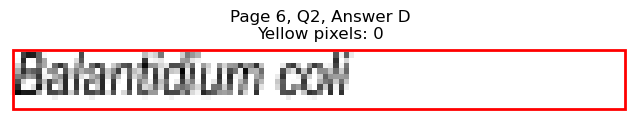


Page 6, Q2 - Selected Answer: C (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=204.7, x1=124.0, y1=215.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 319
Page 6, Q3, A: Yellow percentage: 0.0%


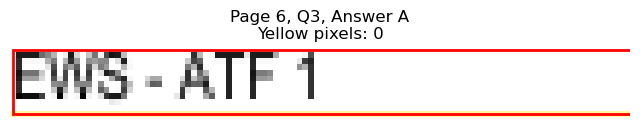

Page 6, Q3 - B: Detected box: x0=68.3, y0=217.4, x1=114.4, y1=228.4
Page 6, Q3, B: Yellow pixels: 913
Page 6, Q3, B: Total non-white pixels: 1164
Page 6, Q3, B: Yellow percentage: 78.4%


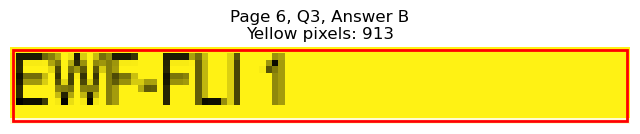

Page 6, Q3 - C: Detected box: x0=327.5, y0=204.7, x1=383.2, y1=215.7
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 229
Page 6, Q3, C: Yellow percentage: 0.0%


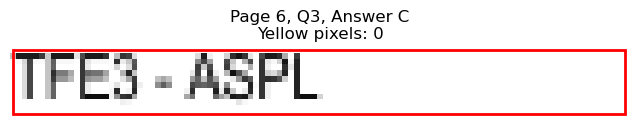

Page 6, Q3 - D: Detected box: x0=327.5, y0=217.4, x1=390.1, y1=228.4
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 292
Page 6, Q3, D: Yellow percentage: 0.0%


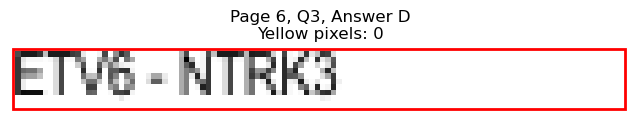


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=255.2, x1=293.4, y1=266.2
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 1126
Page 6, Q4, A: Yellow percentage: 0.0%


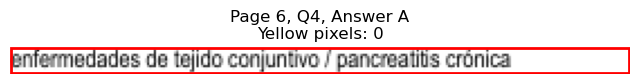

Page 6, Q4 - B: Detected box: x0=68.3, y0=267.8, x1=254.3, y1=278.8
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 949
Page 6, Q4, B: Yellow percentage: 0.0%


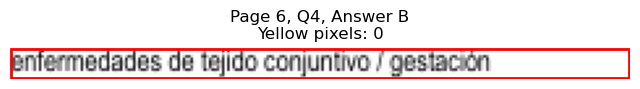

Page 6, Q4 - C: Detected box: x0=68.8, y0=280.5, x1=235.8, y1=291.6
Page 6, Q4, C: Yellow pixels: 218
Page 6, Q4, C: Total non-white pixels: 1057
Page 6, Q4, C: Yellow percentage: 20.6%


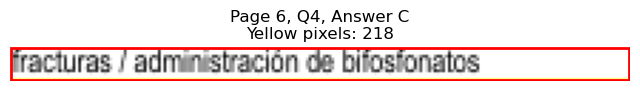

Page 6, Q4 - D: Detected box: x0=68.8, y0=293.1, x1=250.3, y1=304.2
Page 6, Q4, D: Yellow pixels: 1859
Page 6, Q4, D: Total non-white pixels: 2563
Page 6, Q4, D: Yellow percentage: 72.5%


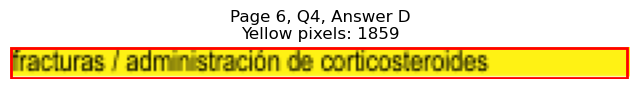


Page 6, Q4 - Selected Answer: D (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=356.2, x1=135.0, y1=367.3
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 328
Page 6, Q5, A: Yellow percentage: 0.0%


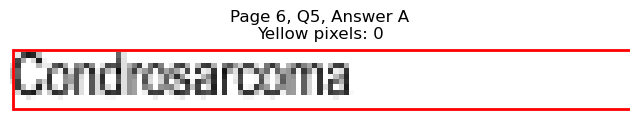

Page 6, Q5 - B: Detected box: x0=68.3, y0=368.8, x1=157.1, y1=379.9
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 468
Page 6, Q5, B: Yellow percentage: 0.0%


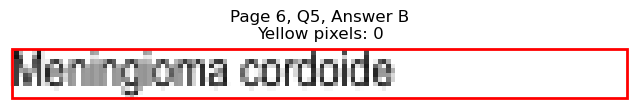

Page 6, Q5 - C: Detected box: x0=327.5, y0=356.2, x1=395.6, y1=367.3
Page 6, Q5, C: Yellow pixels: 119
Page 6, Q5, C: Total non-white pixels: 448
Page 6, Q5, C: Yellow percentage: 26.6%


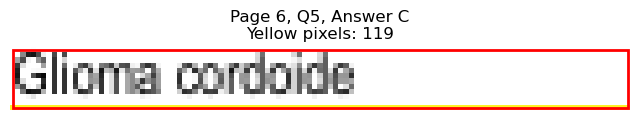

Page 6, Q5 - D: Detected box: x0=327.5, y0=368.8, x1=367.1, y1=379.9
Page 6, Q5, D: Yellow pixels: 941
Page 6, Q5, D: Total non-white pixels: 1092
Page 6, Q5, D: Yellow percentage: 86.2%


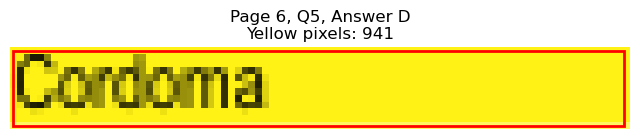


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=406.6, x1=246.2, y1=417.7
Page 6, Q6, A: Yellow pixels: 1837
Page 6, Q6, A: Total non-white pixels: 2568
Page 6, Q6, A: Yellow percentage: 71.5%


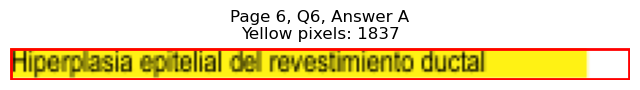

Page 6, Q6 - B: Detected box: x0=68.3, y0=419.4, x1=216.2, y1=430.4
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 774
Page 6, Q6, B: Yellow percentage: 0.0%


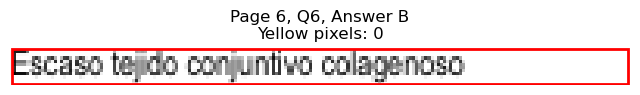

Page 6, Q6 - C: Detected box: x0=327.5, y0=406.6, x1=472.0, y1=417.7
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 751
Page 6, Q6, C: Yellow percentage: 0.0%


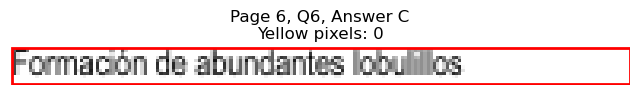

Page 6, Q6 - D: Detected box: x0=327.5, y0=419.4, x1=465.8, y1=430.4
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 707
Page 6, Q6, D: Yellow percentage: 0.0%


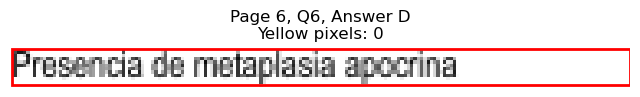


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=495.1, x1=167.5, y1=506.1
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 524
Page 6, Q7, A: Yellow percentage: 0.0%


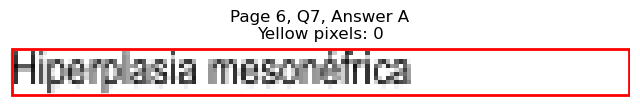

Page 6, Q7 - B: Detected box: x0=68.3, y0=507.7, x1=165.6, y1=518.7
Page 6, Q7, B: Yellow pixels: 148
Page 6, Q7, B: Total non-white pixels: 634
Page 6, Q7, B: Yellow percentage: 23.3%


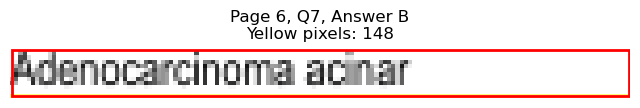

Page 6, Q7 - C: Detected box: x0=68.8, y0=520.3, x1=297.5, y1=531.3
Page 6, Q7, C: Yellow pixels: 2172
Page 6, Q7, C: Total non-white pixels: 3360
Page 6, Q7, C: Yellow percentage: 64.6%


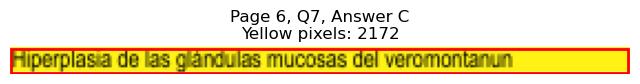

Page 6, Q7 - D: Detected box: x0=68.8, y0=532.9, x1=159.6, y1=543.9
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 450
Page 6, Q7, D: Yellow percentage: 0.0%


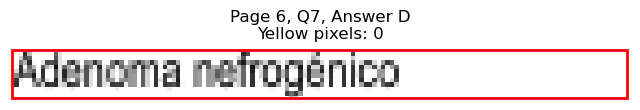


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=608.6, x1=145.0, y1=619.6
Page 6, Q8, A: Yellow pixels: 127
Page 6, Q8, A: Total non-white pixels: 501
Page 6, Q8, A: Yellow percentage: 25.3%


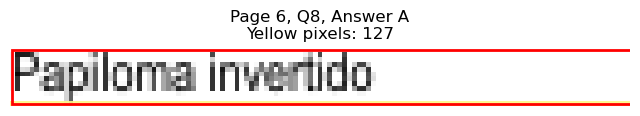

Page 6, Q8 - B: Detected box: x0=68.3, y0=621.3, x1=151.7, y1=632.4
Page 6, Q8, B: Yellow pixels: 1163
Page 6, Q8, B: Total non-white pixels: 1608
Page 6, Q8, B: Yellow percentage: 72.3%


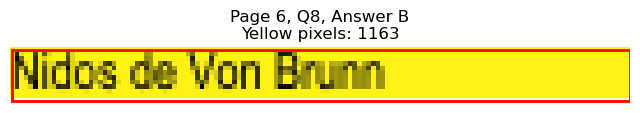

Page 6, Q8 - C: Detected box: x0=327.5, y0=608.6, x1=390.7, y1=619.6
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 334
Page 6, Q8, C: Yellow percentage: 0.0%


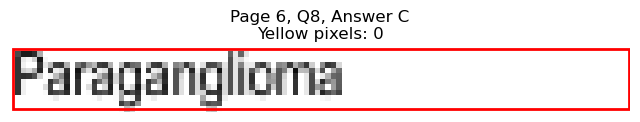

Page 6, Q8 - D: Detected box: x0=327.5, y0=621.3, x1=399.7, y1=632.4
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 352
Page 6, Q8, D: Yellow percentage: 0.0%


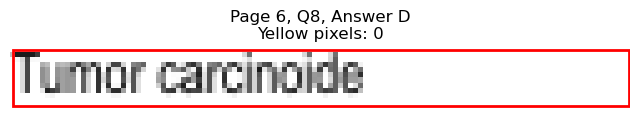


Page 6, Q8 - Selected Answer: B (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=671.7, x1=132.5, y1=682.8
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 327
Page 6, Q9, A: Yellow percentage: 0.0%


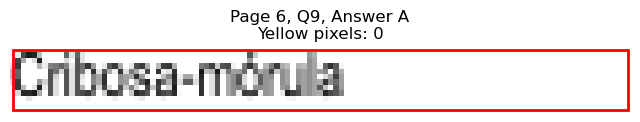

Page 6, Q9 - B: Detected box: x0=68.3, y0=684.3, x1=113.4, y1=695.4
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 233
Page 6, Q9, B: Yellow percentage: 0.0%


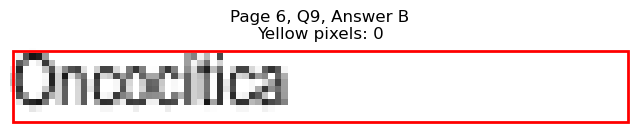

Page 6, Q9 - C: Detected box: x0=327.5, y0=671.7, x1=383.6, y1=682.8
Page 6, Q9, C: Yellow pixels: 1051
Page 6, Q9, C: Total non-white pixels: 1284
Page 6, Q9, C: Yellow percentage: 81.9%


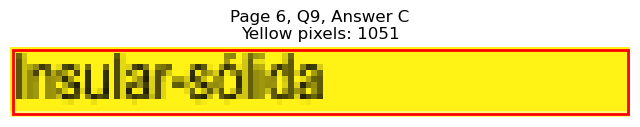

Page 6, Q9 - D: Detected box: x0=327.5, y0=684.3, x1=386.2, y1=695.4
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 317
Page 6, Q9, D: Yellow percentage: 0.0%


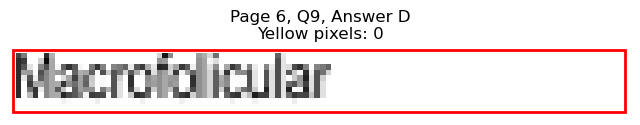


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=734.8, x1=110.4, y1=745.9
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 242
Page 6, Q10, A: Yellow percentage: 0.0%


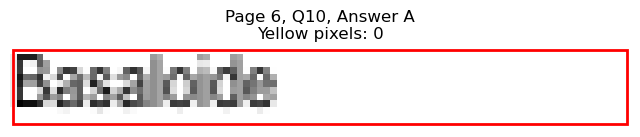

Page 6, Q10 - B: Detected box: x0=68.3, y0=747.4, x1=128.5, y1=758.5
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 319
Page 6, Q10, B: Yellow percentage: 0.0%


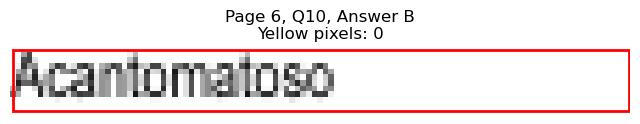

Page 6, Q10 - C: Detected box: x0=327.5, y0=734.8, x1=364.1, y1=745.9
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 272
Page 6, Q10, C: Yellow percentage: 0.0%


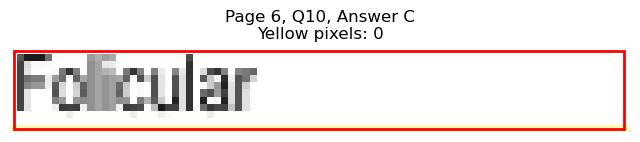

Page 6, Q10 - D: Detected box: x0=327.5, y0=747.4, x1=370.2, y1=758.5
Page 6, Q10, D: Yellow pixels: 863
Page 6, Q10, D: Total non-white pixels: 1128
Page 6, Q10, D: Yellow percentage: 76.5%


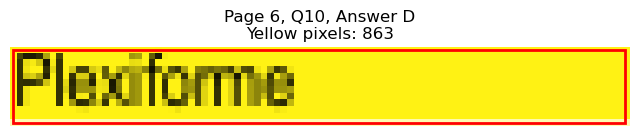


Page 6, Q10 - Selected Answer: D (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=150.0, y1=127.4
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 392
Page 7, Q1, A: Yellow percentage: 0.0%


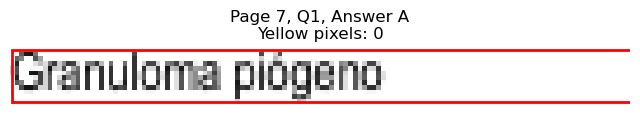

Page 7, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=128.5, y1=140.0
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 317
Page 7, Q1, B: Yellow percentage: 0.0%


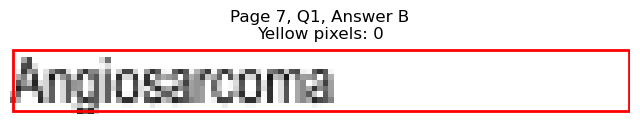

Page 7, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=420.2, y1=127.4
Page 7, Q1, C: Yellow pixels: 144
Page 7, Q1, C: Total non-white pixels: 639
Page 7, Q1, C: Yellow percentage: 22.5%


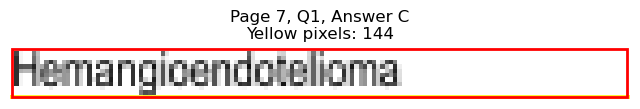

Page 7, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=408.7, y1=140.0
Page 7, Q1, D: Yellow pixels: 1283
Page 7, Q1, D: Total non-white pixels: 1584
Page 7, Q1, D: Yellow percentage: 81.0%


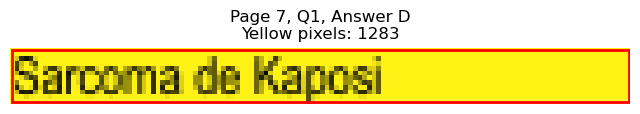


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=204.7, x1=115.0, y1=215.7
Page 7, Q2, A: Yellow pixels: 986
Page 7, Q2, A: Total non-white pixels: 1164
Page 7, Q2, A: Yellow percentage: 84.7%


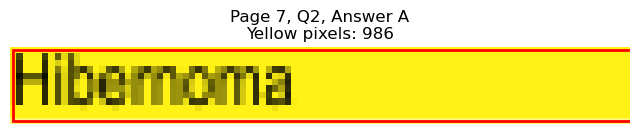

Page 7, Q2 - B: Detected box: x0=68.3, y0=217.4, x1=124.4, y1=228.4
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 292
Page 7, Q2, B: Yellow percentage: 0.0%


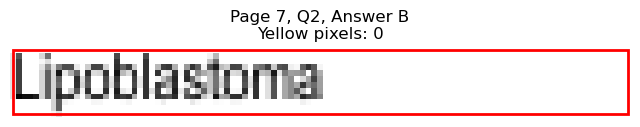

Page 7, Q2 - C: Detected box: x0=327.5, y0=204.7, x1=440.3, y1=215.7
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 568
Page 7, Q2, C: Yellow percentage: 0.0%


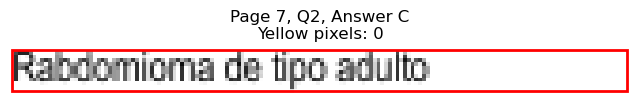

Page 7, Q2 - D: Detected box: x0=327.5, y0=217.4, x1=401.8, y1=228.4
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 348
Page 7, Q2, D: Yellow percentage: 0.0%


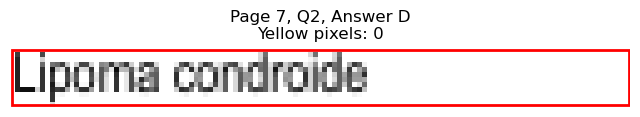


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=293.1, x1=154.6, y1=304.2
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 448
Page 7, Q3, A: Yellow percentage: 0.0%


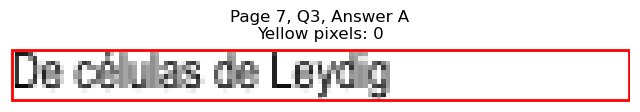

Page 7, Q3 - B: Detected box: x0=68.3, y0=305.7, x1=197.2, y1=316.8
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 628
Page 7, Q3, B: Yellow percentage: 0.0%


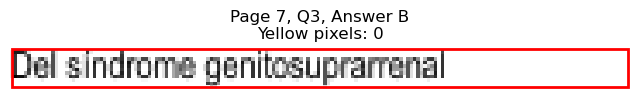

Page 7, Q3 - C: Detected box: x0=327.5, y0=293.1, x1=495.5, y1=304.2
Page 7, Q3, C: Yellow pixels: 1673
Page 7, Q3, C: Total non-white pixels: 2346
Page 7, Q3, C: Yellow percentage: 71.3%


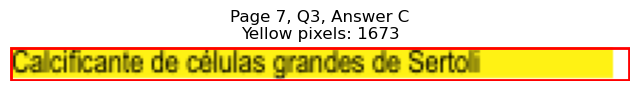

Page 7, Q3 - D: Detected box: x0=327.5, y0=305.7, x1=462.8, y1=316.8
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 674
Page 7, Q3, D: Yellow percentage: 0.0%


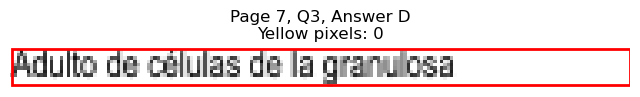


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=356.2, x1=183.1, y1=367.3
Page 7, Q4, A: Yellow pixels: 1373
Page 7, Q4, A: Total non-white pixels: 1992
Page 7, Q4, A: Yellow percentage: 68.9%


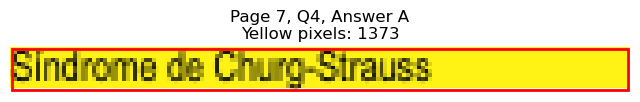

Page 7, Q4 - B: Detected box: x0=68.3, y0=368.8, x1=177.6, y1=379.9
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 588
Page 7, Q4, B: Yellow percentage: 0.0%


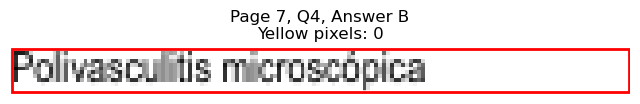

Page 7, Q4 - C: Detected box: x0=327.5, y0=356.2, x1=407.8, y1=367.3
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 394
Page 7, Q4, C: Yellow percentage: 0.0%


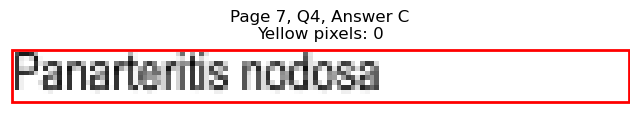

Page 7, Q4 - D: Detected box: x0=327.5, y0=368.8, x1=426.2, y1=379.9
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 506
Page 7, Q4, D: Yellow percentage: 0.0%


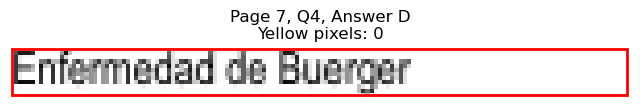


Page 7, Q4 - Selected Answer: A (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=130.0, y1=417.7
Page 7, Q5, A: Yellow pixels: 112
Page 7, Q5, A: Total non-white pixels: 429
Page 7, Q5, A: Yellow percentage: 26.1%


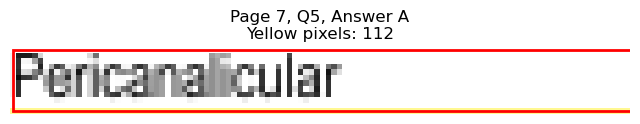

Page 7, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=132.0, y1=430.4
Page 7, Q5, B: Yellow pixels: 999
Page 7, Q5, B: Total non-white pixels: 1368
Page 7, Q5, B: Yellow percentage: 73.0%


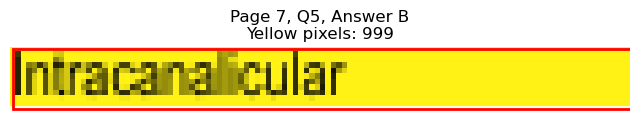

Page 7, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=394.7, y1=417.7
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 348
Page 7, Q5, C: Yellow percentage: 0.0%


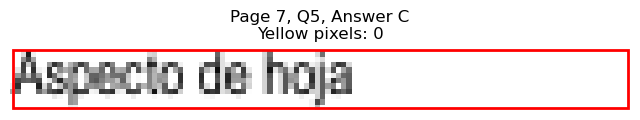

Page 7, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=432.4, y1=430.4
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 566
Page 7, Q5, D: Yellow percentage: 0.0%


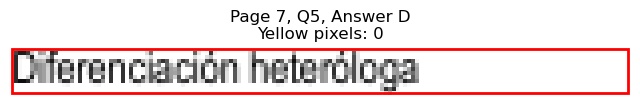


Page 7, Q5 - Selected Answer: B (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=102.4, y1=468.2
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 128
Page 7, Q6, A: Yellow percentage: 0.0%


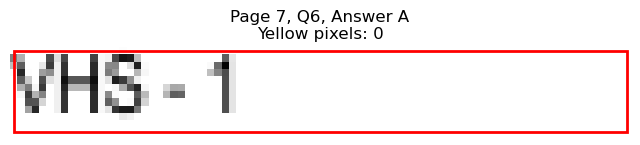

Page 7, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=102.4, y1=480.8
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 134
Page 7, Q6, B: Yellow percentage: 0.0%


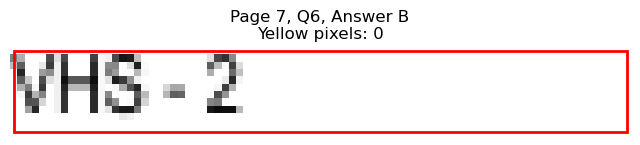

Page 7, Q6 - C: Detected box: x0=327.5, y0=457.2, x1=362.0, y1=468.2
Page 7, Q6, C: Yellow pixels: 836
Page 7, Q6, C: Total non-white pixels: 946
Page 7, Q6, C: Yellow percentage: 88.4%


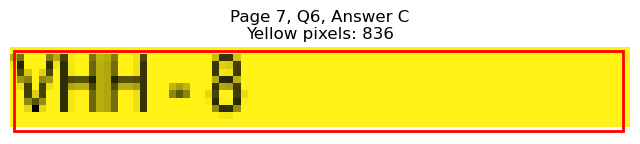

Page 7, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=362.0, y1=480.8
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 144
Page 7, Q6, D: Yellow percentage: 0.0%


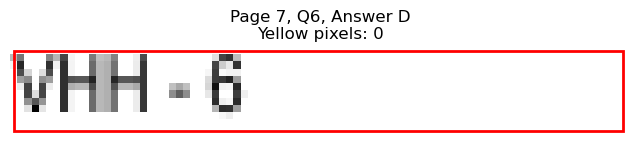


Page 7, Q6 - Selected Answer: C (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=520.3, x1=81.4, y1=531.3
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 42
Page 7, Q7, A: Yellow percentage: 0.0%


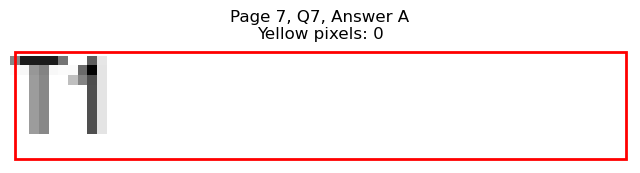

Page 7, Q7 - B: Detected box: x0=68.3, y0=532.9, x1=81.4, y1=543.9
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 52
Page 7, Q7, B: Yellow percentage: 0.0%


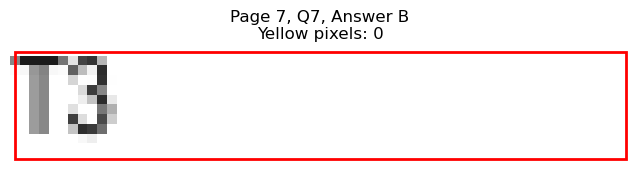

Page 7, Q7 - C: Detected box: x0=327.5, y0=520.3, x1=340.6, y1=531.3
Page 7, Q7, C: Yellow pixels: 64
Page 7, Q7, C: Total non-white pixels: 114
Page 7, Q7, C: Yellow percentage: 56.1%


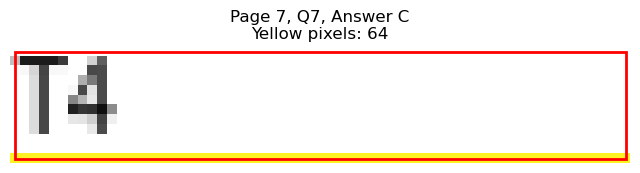

Page 7, Q7 - D: Detected box: x0=327.5, y0=532.9, x1=340.6, y1=543.9
Page 7, Q7, D: Yellow pixels: 732
Page 7, Q7, D: Total non-white pixels: 768
Page 7, Q7, D: Yellow percentage: 95.3%


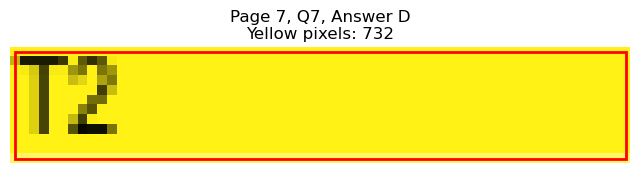


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=608.6, x1=180.6, y1=619.6
Page 7, Q8, A: Yellow pixels: 1512
Page 7, Q8, A: Total non-white pixels: 1956
Page 7, Q8, A: Yellow percentage: 77.3%


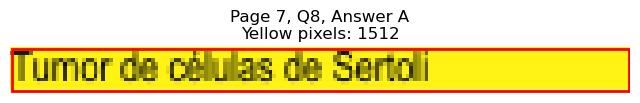

Page 7, Q8 - B: Detected box: x0=68.3, y0=621.3, x1=178.6, y1=632.4
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 551
Page 7, Q8, B: Yellow percentage: 0.0%


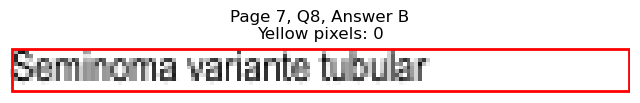

Page 7, Q8 - C: Detected box: x0=327.5, y0=608.6, x1=440.9, y1=619.6
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 552
Page 7, Q8, C: Yellow percentage: 0.0%


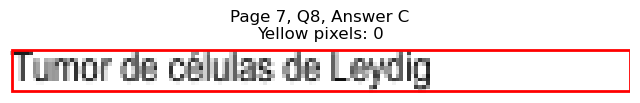

Page 7, Q8 - D: Detected box: x0=327.5, y0=621.3, x1=422.8, y1=632.4
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 466
Page 7, Q8, D: Yellow percentage: 0.0%


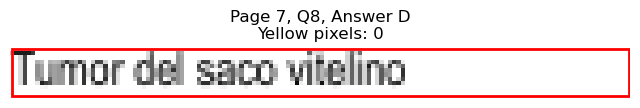


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=697.0, x1=159.6, y1=708.1
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 474
Page 7, Q9, A: Yellow percentage: 0.0%


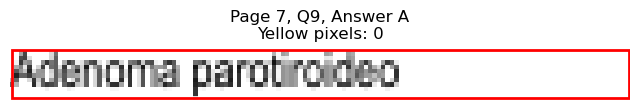

Page 7, Q9 - B: Detected box: x0=68.3, y0=709.6, x1=181.6, y1=720.7
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 576
Page 7, Q9, B: Yellow percentage: 0.0%


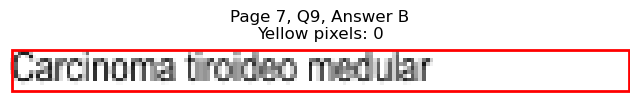

Page 7, Q9 - C: Detected box: x0=327.5, y0=697.0, x1=423.7, y1=708.1
Page 7, Q9, C: Yellow pixels: 1244
Page 7, Q9, C: Total non-white pixels: 1619
Page 7, Q9, C: Yellow percentage: 76.8%


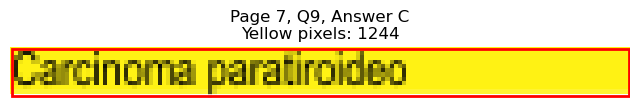

Page 7, Q9 - D: Detected box: x0=327.5, y0=709.6, x1=499.4, y1=720.7
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 869
Page 7, Q9, D: Yellow percentage: 0.0%


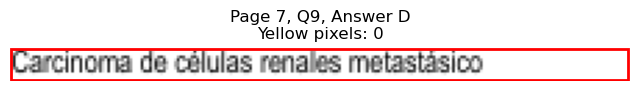


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=161.0, y1=114.8
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 474
Page 8, Q1, A: Yellow percentage: 0.0%


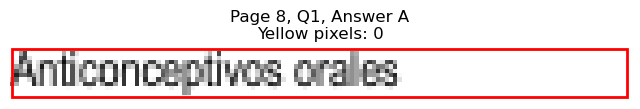

Page 8, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=107.9, y1=127.4
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 224
Page 8, Q1, B: Yellow percentage: 0.0%


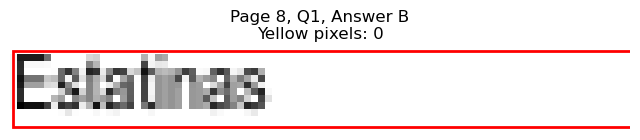

Page 8, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=384.7, y1=114.8
Page 8, Q1, C: Yellow pixels: 1078
Page 8, Q1, C: Total non-white pixels: 1296
Page 8, Q1, C: Yellow percentage: 83.2%


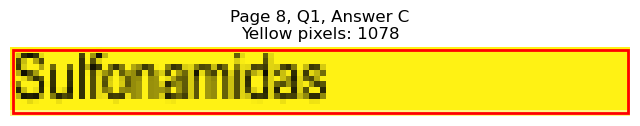

Page 8, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=369.1, y1=127.4
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 232
Page 8, Q1, D: Yellow percentage: 0.0%


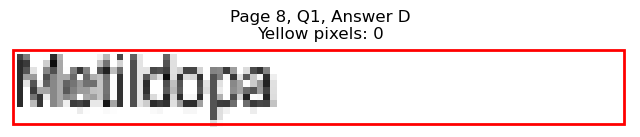


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=115.4, y1=165.3
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 230
Page 8, Q2, A: Yellow percentage: 0.0%


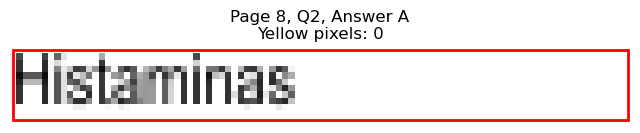

Page 8, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=120.5, y1=177.9
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 252
Page 8, Q2, B: Yellow percentage: 0.0%


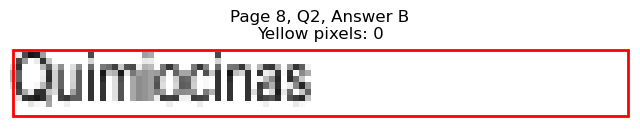

Page 8, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=369.6, y1=165.3
Page 8, Q2, C: Yellow pixels: 851
Page 8, Q2, C: Total non-white pixels: 1116
Page 8, Q2, C: Yellow percentage: 76.3%


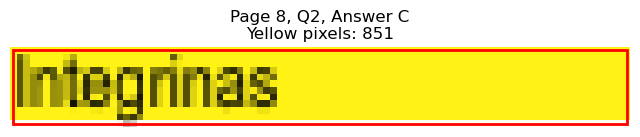

Page 8, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=381.6, y1=177.9
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 242
Page 8, Q2, D: Yellow percentage: 0.0%


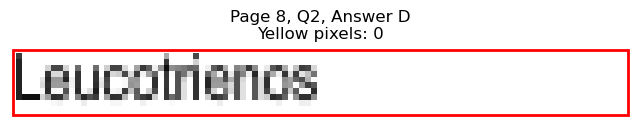


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=118.9, y1=241.0
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 293
Page 8, Q3, A: Yellow percentage: 0.0%


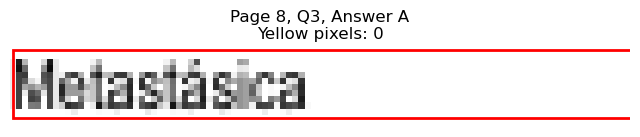

Page 8, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=151.6, y1=253.6
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 428
Page 8, Q3, B: Yellow percentage: 0.0%


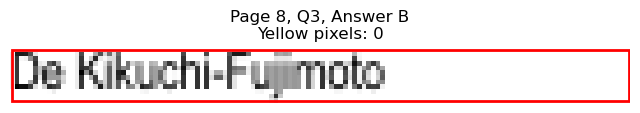

Page 8, Q3 - C: Detected box: x0=327.5, y0=230.0, x1=411.7, y1=241.0
Page 8, Q3, C: Yellow pixels: 1300
Page 8, Q3, C: Total non-white pixels: 1622
Page 8, Q3, C: Yellow percentage: 80.1%


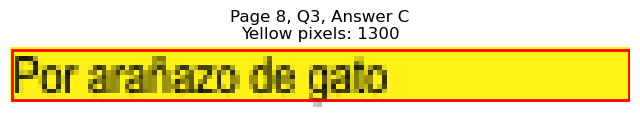

Page 8, Q3 - D: Detected box: x0=327.5, y0=242.6, x1=382.8, y1=253.6
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 283
Page 8, Q3, D: Yellow percentage: 0.0%


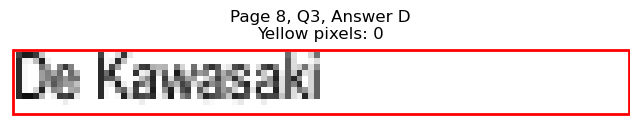


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=119.4, y1=342.0
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 272
Page 8, Q4, A: Yellow percentage: 0.0%


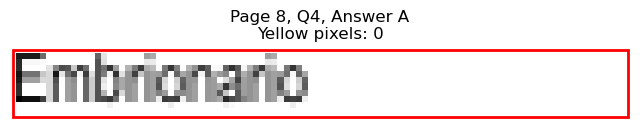

Page 8, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=123.0, y1=354.7
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 289
Page 8, Q4, B: Yellow percentage: 0.0%


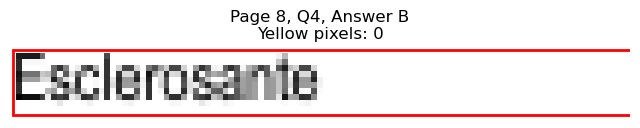

Page 8, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=362.6, y1=342.0
Page 8, Q4, C: Yellow pixels: 895
Page 8, Q4, C: Total non-white pixels: 1032
Page 8, Q4, C: Yellow percentage: 86.7%


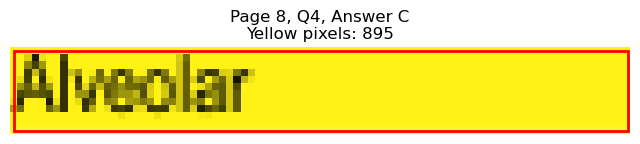

Page 8, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=368.2, y1=354.7
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 186
Page 8, Q4, D: Yellow percentage: 0.0%


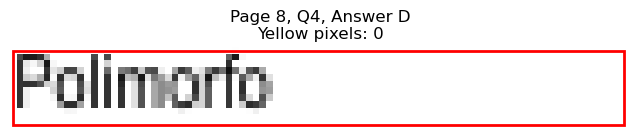


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=419.4, x1=211.2, y1=430.4
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 728
Page 8, Q5, A: Yellow percentage: 0.0%


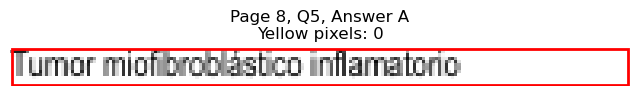

Page 8, Q5 - B: Detected box: x0=68.3, y0=432.0, x1=122.4, y1=443.0
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 273
Page 8, Q5, B: Yellow percentage: 0.0%


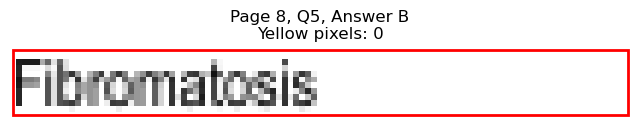

Page 8, Q5 - C: Detected box: x0=327.5, y0=419.4, x1=440.3, y1=430.4
Page 8, Q5, C: Yellow pixels: 1374
Page 8, Q5, C: Total non-white pixels: 1968
Page 8, Q5, C: Yellow percentage: 69.8%


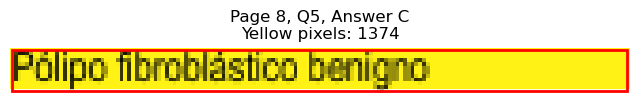

Page 8, Q5 - D: Detected box: x0=327.5, y0=432.0, x1=440.3, y1=443.0
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 579
Page 8, Q5, D: Yellow percentage: 0.0%


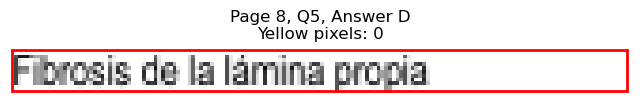


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=226.2, y1=493.5
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 680
Page 8, Q6, A: Yellow percentage: 0.0%


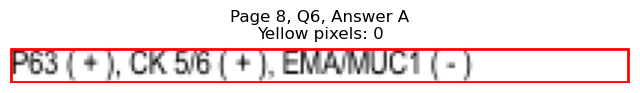

Page 8, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=223.9, y1=506.1
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 678
Page 8, Q6, B: Yellow percentage: 0.0%


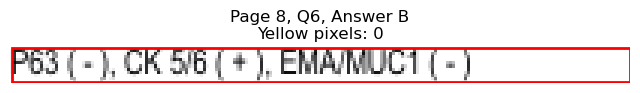

Page 8, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=490.2, y1=493.5
Page 8, Q6, C: Yellow pixels: 1828
Page 8, Q6, C: Total non-white pixels: 2556
Page 8, Q6, C: Yellow percentage: 71.5%


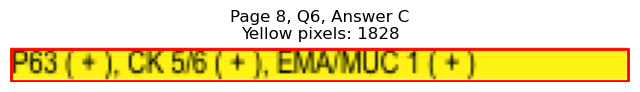

Page 8, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=483.1, y1=506.1
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 652
Page 8, Q6, D: Yellow percentage: 0.0%


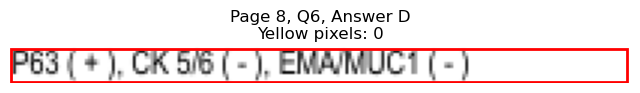


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=570.8, x1=181.1, y1=581.8
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 580
Page 8, Q7, A: Yellow percentage: 0.0%


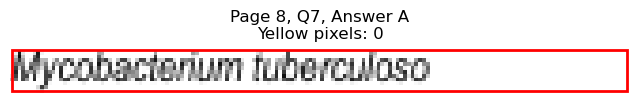

Page 8, Q7 - B: Detected box: x0=68.3, y0=583.4, x1=164.0, y1=594.4
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 484
Page 8, Q7, B: Yellow percentage: 0.0%


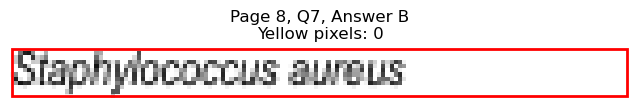

Page 8, Q7 - C: Detected box: x0=327.5, y0=570.8, x1=405.2, y1=581.8
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 535
Page 8, Q7, C: Yellow percentage: 0.0%


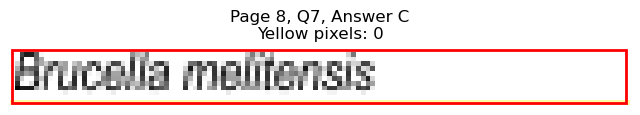

Page 8, Q7 - D: Detected box: x0=327.5, y0=583.4, x1=412.2, y1=594.4
Page 8, Q7, D: Yellow pixels: 1155
Page 8, Q7, D: Total non-white pixels: 1632
Page 8, Q7, D: Yellow percentage: 70.8%


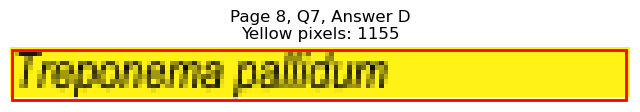


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=633.9, x1=131.5, y1=645.0
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 336
Page 8, Q8, A: Yellow percentage: 0.0%


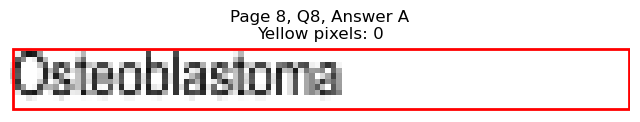

Page 8, Q8 - B: Detected box: x0=68.3, y0=646.5, x1=107.4, y1=657.6
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 202
Page 8, Q8, B: Yellow percentage: 0.0%


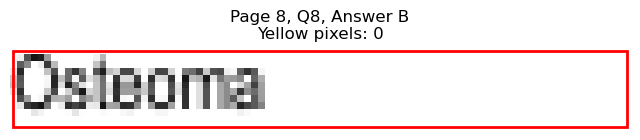

Page 8, Q8 - C: Detected box: x0=327.5, y0=633.9, x1=403.2, y1=645.0
Page 8, Q8, C: Yellow pixels: 1239
Page 8, Q8, C: Total non-white pixels: 1524
Page 8, Q8, C: Yellow percentage: 81.3%


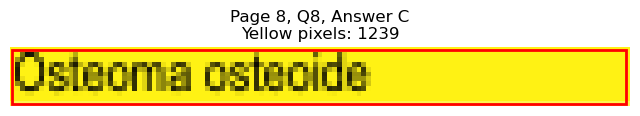

Page 8, Q8 - D: Detected box: x0=327.5, y0=646.5, x1=385.7, y1=657.6
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 279
Page 8, Q8, D: Yellow percentage: 0.0%


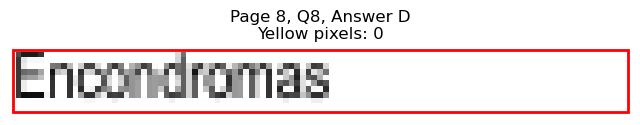


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=684.3, x1=226.3, y1=695.4
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 768
Page 8, Q9, A: Yellow percentage: 0.0%


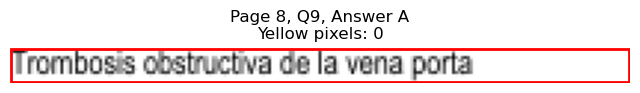

Page 8, Q9 - B: Detected box: x0=68.3, y0=697.0, x1=251.9, y1=708.1
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 921
Page 8, Q9, B: Yellow percentage: 0.0%


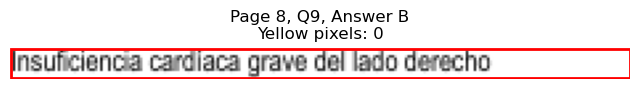

Page 8, Q9 - C: Detected box: x0=327.5, y0=684.3, x1=360.6, y1=695.4
Page 8, Q9, C: Yellow pixels: 794
Page 8, Q9, C: Total non-white pixels: 1008
Page 8, Q9, C: Yellow percentage: 78.8%


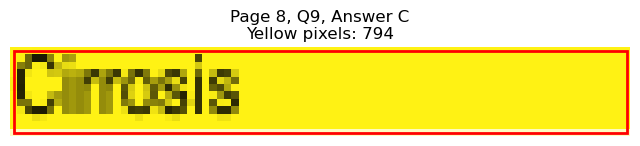

Page 8, Q9 - D: Detected box: x0=327.5, y0=697.0, x1=422.3, y1=708.1
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 493
Page 8, Q9, D: Yellow percentage: 0.0%


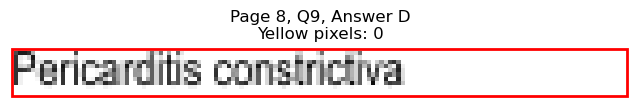


Page 8, Q9 - Selected Answer: C (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=747.4, x1=158.0, y1=758.5
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 439
Page 8, Q10, A: Yellow percentage: 0.0%


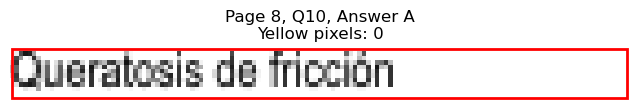

Page 8, Q10 - B: Detected box: x0=68.3, y0=760.2, x1=118.9, y1=771.2
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 261
Page 8, Q10, B: Yellow percentage: 0.0%


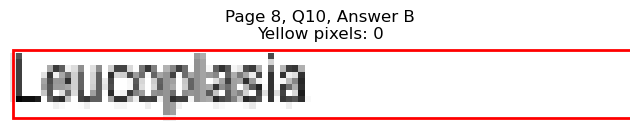

Page 8, Q10 - C: Detected box: x0=327.5, y0=747.4, x1=408.7, y1=758.5
Page 8, Q10, C: Yellow pixels: 1159
Page 8, Q10, C: Total non-white pixels: 1584
Page 8, Q10, C: Yellow percentage: 73.2%


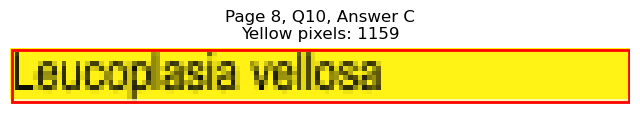

Page 8, Q10 - D: Detected box: x0=327.5, y0=760.2, x1=427.3, y1=771.2
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 570
Page 8, Q10, D: Yellow percentage: 0.0%


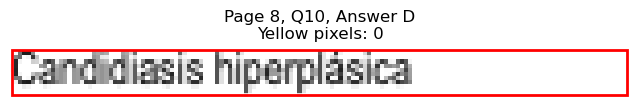


Page 8, Q10 - Selected Answer: C (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=131.5, y1=140.0
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 336
Page 9, Q1, A: Yellow percentage: 0.0%


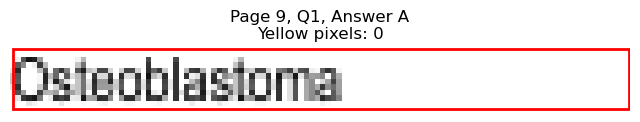

Page 9, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=129.5, y1=152.7
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 321
Page 9, Q1, B: Yellow percentage: 0.0%


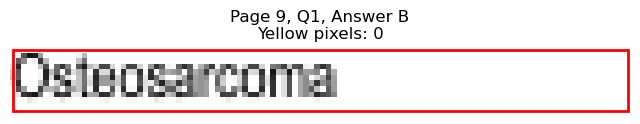

Page 9, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=394.2, y1=140.0
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 457
Page 9, Q1, C: Yellow percentage: 0.0%


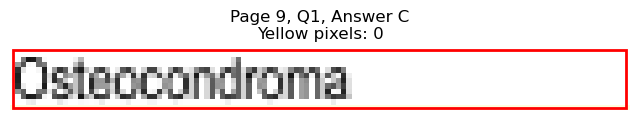

Page 9, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=403.2, y1=152.7
Page 9, Q1, D: Yellow pixels: 1239
Page 9, Q1, D: Total non-white pixels: 1524
Page 9, Q1, D: Yellow percentage: 81.3%


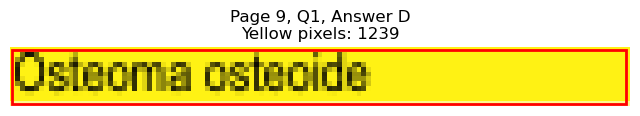


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=157.1, y1=203.1
Page 9, Q2, A: Yellow pixels: 140
Page 9, Q2, A: Total non-white pixels: 703
Page 9, Q2, A: Yellow percentage: 19.9%


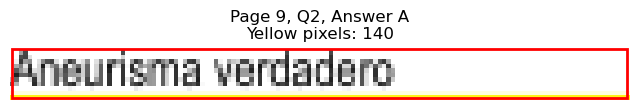

Page 9, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=137.5, y1=215.7
Page 9, Q2, B: Yellow pixels: 1163
Page 9, Q2, B: Total non-white pixels: 1440
Page 9, Q2, B: Yellow percentage: 80.8%


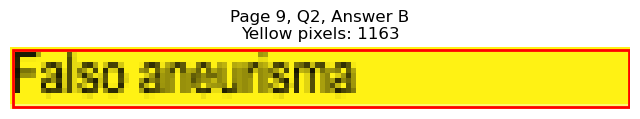

Page 9, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=369.1, y1=203.1
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 215
Page 9, Q2, C: Yellow percentage: 0.0%


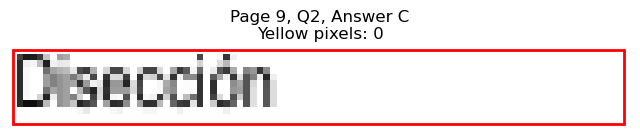

Page 9, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=383.2, y1=215.7
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 294
Page 9, Q2, D: Yellow percentage: 0.0%


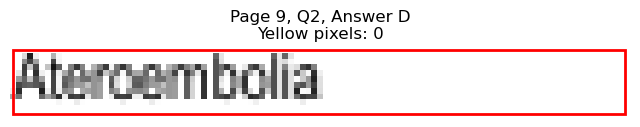


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=228.7, y1=253.6
Page 9, Q3, A: Yellow pixels: 1712
Page 9, Q3, A: Total non-white pixels: 2532
Page 9, Q3, A: Yellow percentage: 67.6%


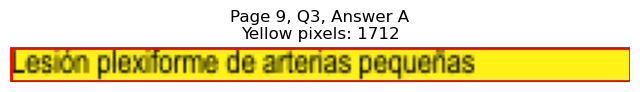

Page 9, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=183.6, y1=266.2
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 598
Page 9, Q3, B: Yellow percentage: 0.0%


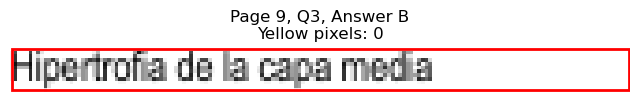

Page 9, Q3 - C: Detected box: x0=327.5, y0=242.6, x1=475.4, y1=253.6
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 724
Page 9, Q3, C: Yellow percentage: 0.0%


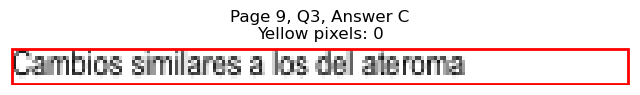

Page 9, Q3 - D: Detected box: x0=327.5, y0=255.2, x1=432.8, y1=266.2
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 529
Page 9, Q3, D: Yellow percentage: 0.0%


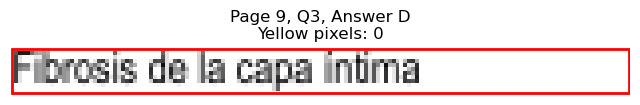


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=143.0, y1=342.0
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 374
Page 9, Q4, A: Yellow percentage: 0.0%


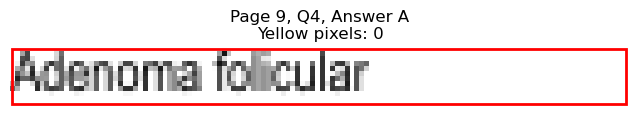

Page 9, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=169.6, y1=354.7
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 513
Page 9, Q4, B: Yellow percentage: 0.0%


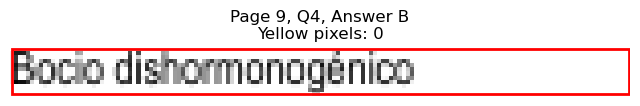

Page 9, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=424.2, y1=342.0
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 618
Page 9, Q4, C: Yellow percentage: 0.0%


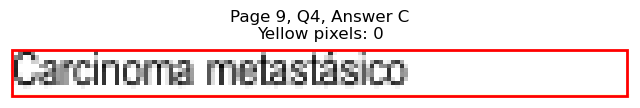

Page 9, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=418.3, y1=354.7
Page 9, Q4, D: Yellow pixels: 1344
Page 9, Q4, D: Total non-white pixels: 1704
Page 9, Q4, D: Yellow percentage: 78.9%


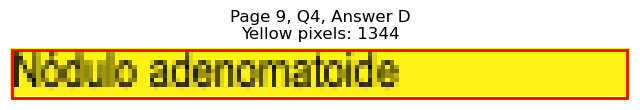


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=174.1, y1=405.1
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 522
Page 9, Q5, A: Yellow percentage: 0.0%


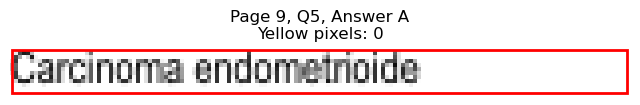

Page 9, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=136.4, y1=417.7
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 338
Page 9, Q5, B: Yellow percentage: 0.0%


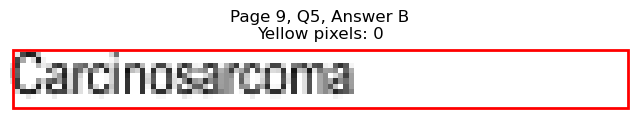

Page 9, Q5 - C: Detected box: x0=327.5, y0=394.0, x1=390.7, y1=405.1
Page 9, Q5, C: Yellow pixels: 114
Page 9, Q5, C: Total non-white pixels: 534
Page 9, Q5, C: Yellow percentage: 21.3%


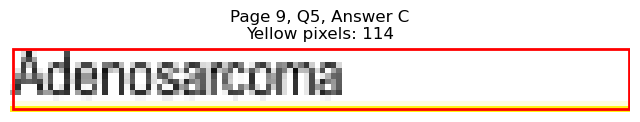

Page 9, Q5 - D: Detected box: x0=327.5, y0=406.6, x1=403.2, y1=417.7
Page 9, Q5, D: Yellow pixels: 1243
Page 9, Q5, D: Total non-white pixels: 1524
Page 9, Q5, D: Yellow percentage: 81.6%


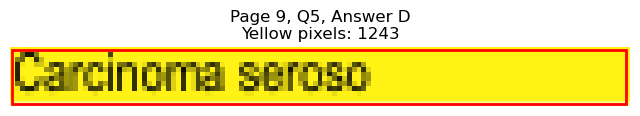


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=444.6, x1=142.4, y1=455.6
Page 9, Q6, A: Yellow pixels: 1097
Page 9, Q6, A: Total non-white pixels: 1500
Page 9, Q6, A: Yellow percentage: 73.1%


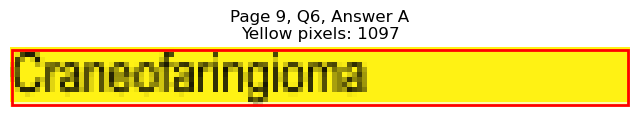

Page 9, Q6 - B: Detected box: x0=68.3, y0=457.2, x1=155.0, y1=468.2
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 431
Page 9, Q6, B: Yellow percentage: 0.0%


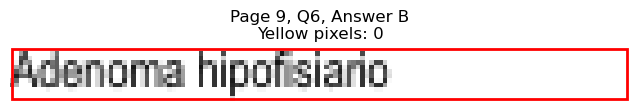

Page 9, Q6 - C: Detected box: x0=327.5, y0=444.6, x1=358.6, y1=455.6
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 139
Page 9, Q6, C: Yellow percentage: 0.0%


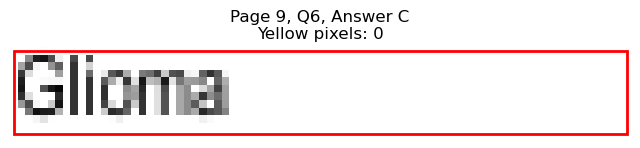

Page 9, Q6 - D: Detected box: x0=327.5, y0=457.2, x1=379.1, y1=468.2
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 285
Page 9, Q6, D: Yellow percentage: 0.0%


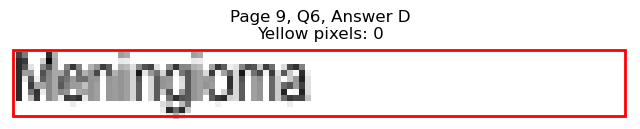


Page 9, Q6 - Selected Answer: A (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=495.1, x1=204.1, y1=506.1
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 682
Page 9, Q7, A: Yellow percentage: 0.0%


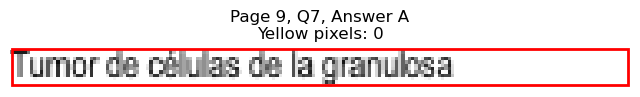

Page 9, Q7 - B: Detected box: x0=68.3, y0=507.7, x1=210.2, y1=518.7
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 726
Page 9, Q7, B: Yellow percentage: 0.0%


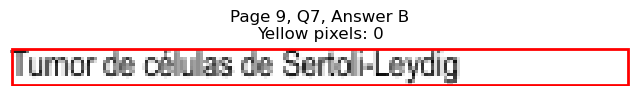

Page 9, Q7 - C: Detected box: x0=327.5, y0=495.1, x1=362.6, y1=506.1
Page 9, Q7, C: Yellow pixels: 86
Page 9, Q7, C: Total non-white pixels: 335
Page 9, Q7, C: Yellow percentage: 25.7%


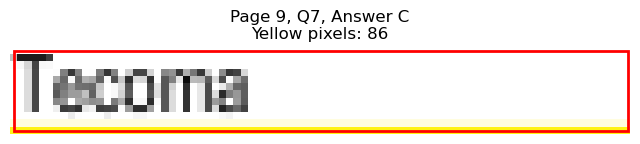

Page 9, Q7 - D: Detected box: x0=327.5, y0=507.7, x1=388.2, y1=518.7
Page 9, Q7, D: Yellow pixels: 1101
Page 9, Q7, D: Total non-white pixels: 1344
Page 9, Q7, D: Yellow percentage: 81.9%


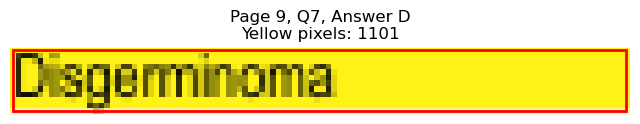


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=583.4, x1=124.0, y1=594.4
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 278
Page 9, Q8, A: Yellow percentage: 0.0%


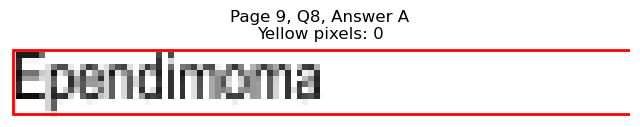

Page 9, Q8 - B: Detected box: x0=68.3, y0=596.0, x1=137.0, y1=607.0
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 390
Page 9, Q8, B: Yellow percentage: 0.0%


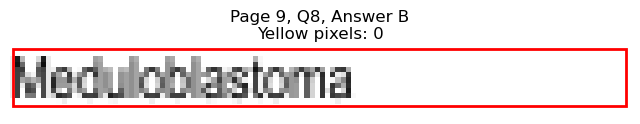

Page 9, Q8 - C: Detected box: x0=327.5, y0=583.4, x1=405.7, y1=594.4
Page 9, Q8, C: Yellow pixels: 1131
Page 9, Q8, C: Total non-white pixels: 1548
Page 9, Q8, C: Yellow percentage: 73.1%


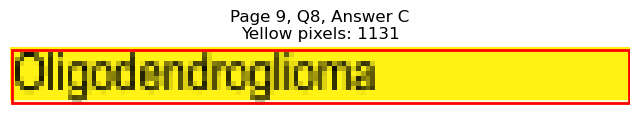

Page 9, Q8 - D: Detected box: x0=327.5, y0=457.2, x1=379.1, y1=468.2
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 285
Page 9, Q8, D: Yellow percentage: 0.0%


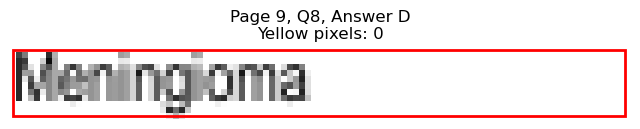


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=444.6, x1=142.4, y1=455.6
Page 9, Q9, A: Yellow pixels: 1097
Page 9, Q9, A: Total non-white pixels: 1500
Page 9, Q9, A: Yellow percentage: 73.1%


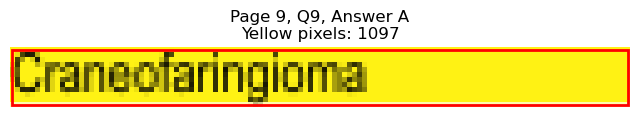

Page 9, Q9 - B: Detected box: x0=68.3, y0=659.1, x1=140.5, y1=670.2
Page 9, Q9, B: Yellow pixels: 1062
Page 9, Q9, B: Total non-white pixels: 1353
Page 9, Q9, B: Yellow percentage: 78.5%


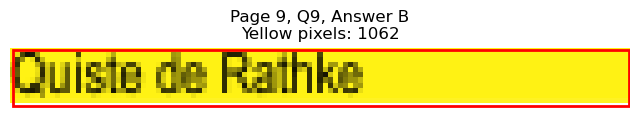

Page 9, Q9 - C: Detected box: x0=327.5, y0=646.5, x1=408.2, y1=657.6
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 423
Page 9, Q9, C: Yellow percentage: 0.0%


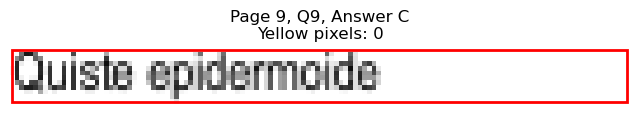

Page 9, Q9 - D: Detected box: x0=327.5, y0=659.1, x1=476.4, y1=670.2
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 749
Page 9, Q9, D: Yellow percentage: 0.0%


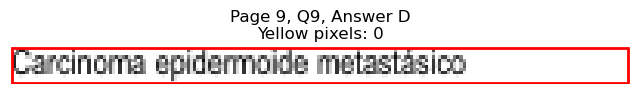


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=722.2, x1=229.3, y1=733.3
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 816
Page 9, Q10, A: Yellow percentage: 0.0%


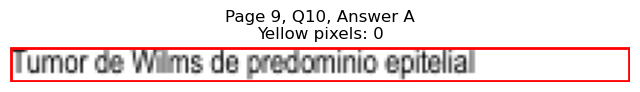

Page 9, Q10 - B: Detected box: x0=68.3, y0=734.8, x1=166.6, y1=745.9
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 480
Page 9, Q10, B: Yellow percentage: 0.0%


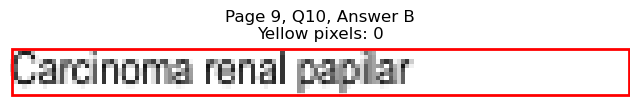

Page 9, Q10 - C: Detected box: x0=327.5, y0=722.2, x1=398.2, y1=733.3
Page 9, Q10, C: Yellow pixels: 122
Page 9, Q10, C: Total non-white pixels: 485
Page 9, Q10, C: Yellow percentage: 25.2%


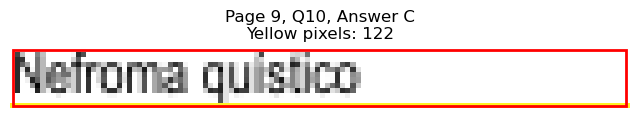

Page 9, Q10 - D: Detected box: x0=327.5, y0=734.8, x1=418.2, y1=745.9
Page 9, Q10, D: Yellow pixels: 1372
Page 9, Q10, D: Total non-white pixels: 1704
Page 9, Q10, D: Yellow percentage: 80.5%


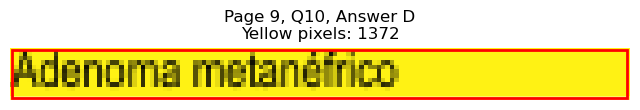


Page 9, Q10 - Selected Answer: D (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=257.9, y1=114.8
Page 10, Q1, A: Yellow pixels: 1814
Page 10, Q1, A: Total non-white pixels: 2568
Page 10, Q1, A: Yellow percentage: 70.6%


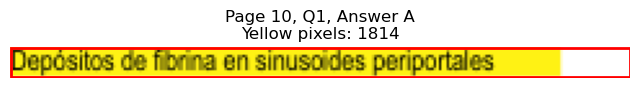

Page 10, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=199.1, y1=127.4
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 688
Page 10, Q1, B: Yellow percentage: 0.0%


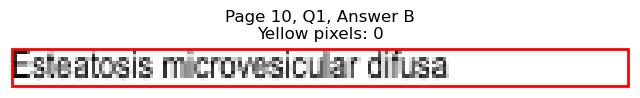

Page 10, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=478.3, y1=114.8
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 808
Page 10, Q1, C: Yellow percentage: 0.0%


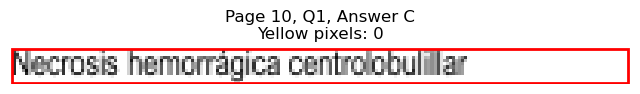

Page 10, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=425.8, y1=127.4
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 543
Page 10, Q1, D: Yellow percentage: 0.0%


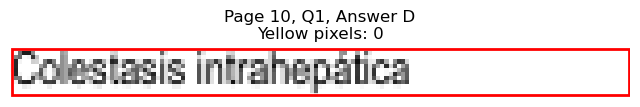


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=231.8, y1=203.1
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 858
Page 10, Q2, A: Yellow percentage: 0.0%


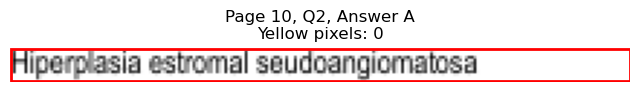

Page 10, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=173.6, y1=215.7
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 529
Page 10, Q2, B: Yellow percentage: 0.0%


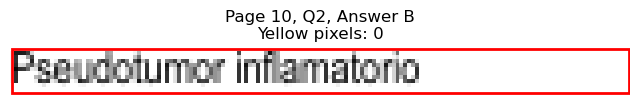

Page 10, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=442.8, y1=203.1
Page 10, Q2, C: Yellow pixels: 1347
Page 10, Q2, C: Total non-white pixels: 1828
Page 10, Q2, C: Yellow percentage: 73.7%


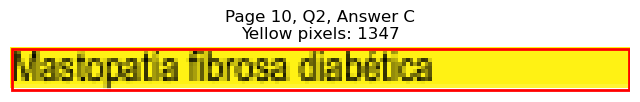

Page 10, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=499.4, y1=215.7
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 852
Page 10, Q2, D: Yellow percentage: 0.0%


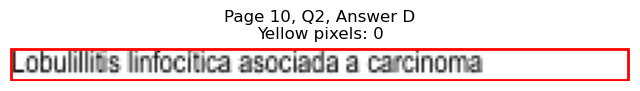


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=280.5, x1=159.1, y1=291.6
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 472
Page 10, Q3, A: Yellow percentage: 0.0%


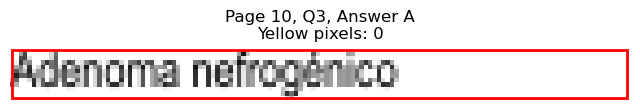

Page 10, Q3 - B: Detected box: x0=68.3, y0=293.1, x1=174.6, y1=304.2
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 571
Page 10, Q3, B: Yellow percentage: 0.0%


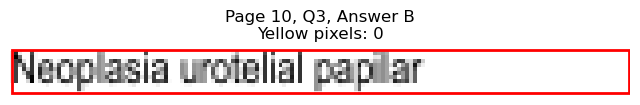

Page 10, Q3 - C: Detected box: x0=327.5, y0=280.5, x1=424.8, y1=291.6
Page 10, Q3, C: Yellow pixels: 1231
Page 10, Q3, C: Total non-white pixels: 1776
Page 10, Q3, C: Yellow percentage: 69.3%


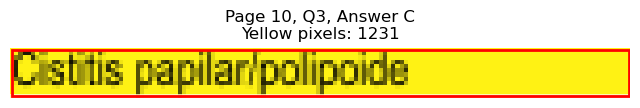

Page 10, Q3 - D: Detected box: x0=327.5, y0=293.1, x1=405.7, y1=304.2
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 419
Page 10, Q3, D: Yellow percentage: 0.0%


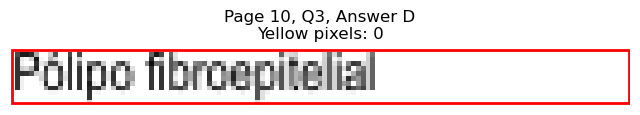


Page 10, Q3 - Selected Answer: C (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=368.8, x1=232.8, y1=379.9
Page 10, Q4, A: Yellow pixels: 2
Page 10, Q4, A: Total non-white pixels: 1058
Page 10, Q4, A: Yellow percentage: 0.2%


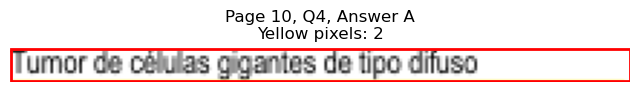

Page 10, Q4 - B: Detected box: x0=68.3, y0=381.4, x1=264.4, y1=392.5
Page 10, Q4, B: Yellow pixels: 1579
Page 10, Q4, B: Total non-white pixels: 2568
Page 10, Q4, B: Yellow percentage: 61.5%


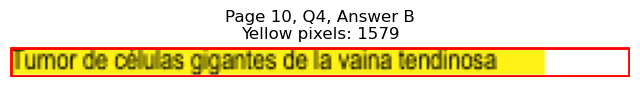

Page 10, Q4 - C: Detected box: x0=327.5, y0=368.8, x1=477.5, y1=379.9
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 763
Page 10, Q4, C: Yellow percentage: 0.0%


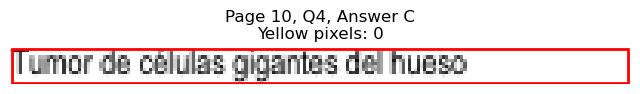

Page 10, Q4 - D: Detected box: x0=327.5, y0=381.4, x1=424.3, y1=392.5
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 514
Page 10, Q4, D: Yellow percentage: 0.0%


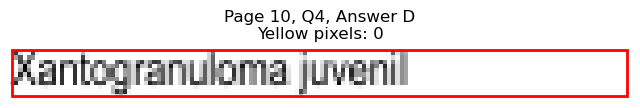


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=432.0, x1=235.3, y1=443.0
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 833
Page 10, Q5, A: Yellow percentage: 0.0%


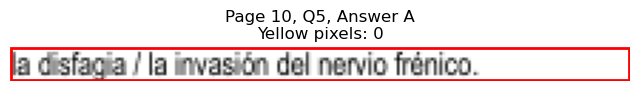

Page 10, Q5 - B: Detected box: x0=68.3, y0=444.6, x1=218.3, y1=455.6
Page 10, Q5, B: Yellow pixels: 201
Page 10, Q5, B: Total non-white pixels: 944
Page 10, Q5, B: Yellow percentage: 21.3%


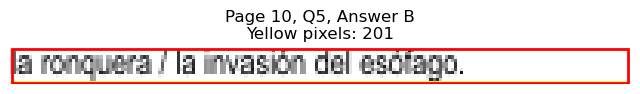

Page 10, Q5 - C: Detected box: x0=68.8, y0=457.2, x1=307.4, y1=468.2
Page 10, Q5, C: Yellow pixels: 2326
Page 10, Q5, C: Total non-white pixels: 3196
Page 10, Q5, C: Yellow percentage: 72.8%


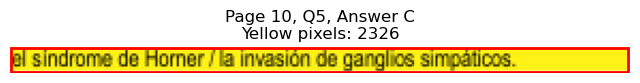

Page 10, Q5 - D: Detected box: x0=68.8, y0=469.8, x1=344.5, y1=480.8
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 1278
Page 10, Q5, D: Yellow percentage: 0.0%


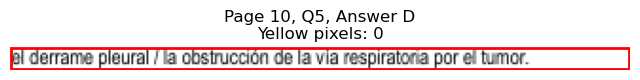


Page 10, Q5 - Selected Answer: C (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=520.3, x1=176.0, y1=531.3
Page 10, Q6, A: Yellow pixels: 159
Page 10, Q6, A: Total non-white pixels: 638
Page 10, Q6, A: Yellow percentage: 24.9%


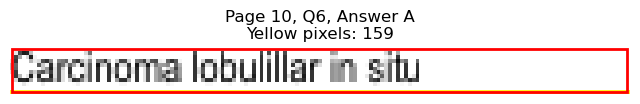

Page 10, Q6 - B: Detected box: x0=68.3, y0=532.9, x1=167.0, y1=543.9
Page 10, Q6, B: Yellow pixels: 1454
Page 10, Q6, B: Total non-white pixels: 1800
Page 10, Q6, B: Yellow percentage: 80.8%


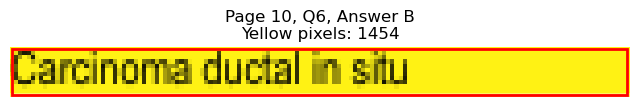

Page 10, Q6 - C: Detected box: x0=327.5, y0=520.3, x1=430.8, y1=531.3
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 565
Page 10, Q6, C: Yellow percentage: 0.0%


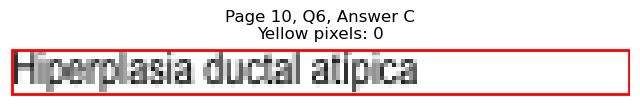

Page 10, Q6 - D: Detected box: x0=327.5, y0=532.9, x1=450.4, y1=543.9
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 684
Page 10, Q6, D: Yellow percentage: 0.0%


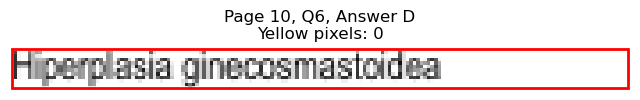


Page 10, Q6 - Selected Answer: B (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=583.4, x1=176.2, y1=594.4
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 570
Page 10, Q7, A: Yellow percentage: 0.0%


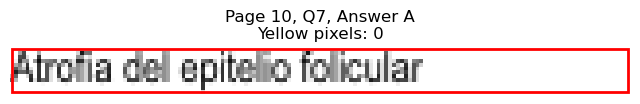

Page 10, Q7 - B: Detected box: x0=68.3, y0=596.0, x1=246.8, y1=607.0
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 928
Page 10, Q7, B: Yellow percentage: 0.0%


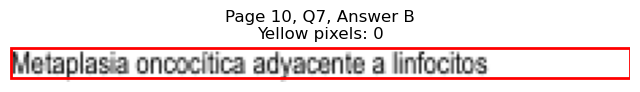

Page 10, Q7 - C: Detected box: x0=327.5, y0=583.4, x1=493.0, y1=594.4
Page 10, Q7, C: Yellow pixels: 1736
Page 10, Q7, C: Total non-white pixels: 2556
Page 10, Q7, C: Yellow percentage: 67.9%


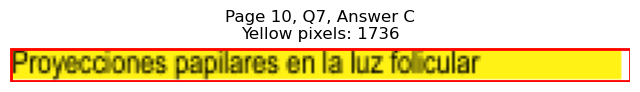

Page 10, Q7 - D: Detected box: x0=327.5, y0=596.0, x1=404.8, y1=607.0
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 376
Page 10, Q7, D: Yellow percentage: 0.0%


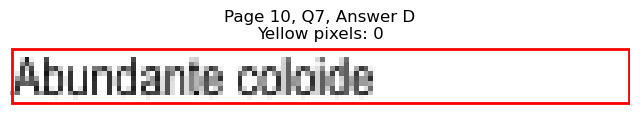


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=646.5, x1=187.7, y1=657.6
Page 10, Q8, A: Yellow pixels: 170
Page 10, Q8, A: Total non-white pixels: 782
Page 10, Q8, A: Yellow percentage: 21.7%


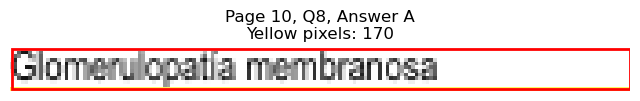

Page 10, Q8 - B: Detected box: x0=68.3, y0=659.1, x1=198.6, y1=670.2
Page 10, Q8, B: Yellow pixels: 1448
Page 10, Q8, B: Total non-white pixels: 1993
Page 10, Q8, B: Yellow percentage: 72.7%


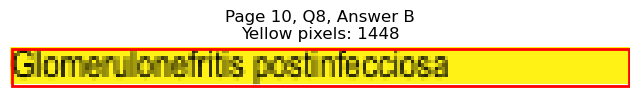

Page 10, Q8 - C: Detected box: x0=327.5, y0=646.5, x1=390.7, y1=657.6
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 307
Page 10, Q8, C: Yellow percentage: 0.0%


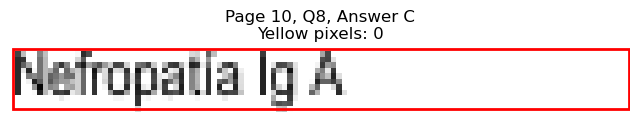

Page 10, Q8 - D: Detected box: x0=327.5, y0=659.1, x1=495.5, y1=670.2
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 905
Page 10, Q8, D: Yellow percentage: 0.0%


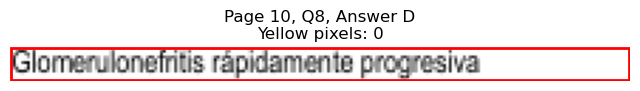


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=68.3, y0=697.0, x1=208.2, y1=708.1
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 719
Page 10, Q9, A: Yellow percentage: 0.0%


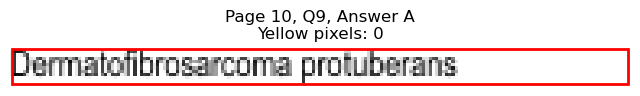

Page 10, Q9 - B: Detected box: x0=68.3, y0=709.6, x1=120.5, y1=720.7
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 287
Page 10, Q9, B: Yellow percentage: 0.0%


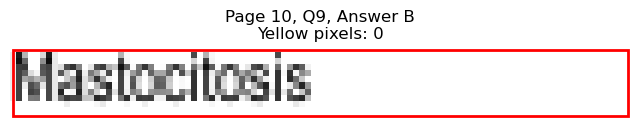

Page 10, Q9 - C: Detected box: x0=327.5, y0=697.0, x1=366.6, y1=708.1
Page 10, Q9, C: Yellow pixels: 90
Page 10, Q9, C: Total non-white pixels: 380
Page 10, Q9, C: Yellow percentage: 23.7%


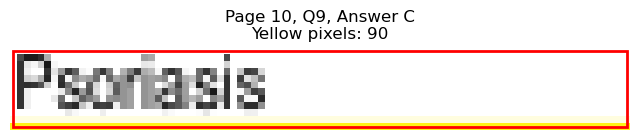

Page 10, Q9 - D: Detected box: x0=327.5, y0=709.6, x1=394.8, y1=720.7
Page 10, Q9, D: Yellow pixels: 1135
Page 10, Q9, D: Total non-white pixels: 1416
Page 10, Q9, D: Yellow percentage: 80.2%


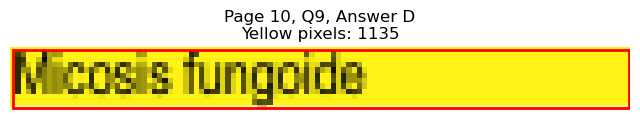


Page 10, Q9 - Selected Answer: D (based on yellow pixel count)





Page 11: Found 4 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=109.4, y1=114.8
Page 11, Q1, A: Yellow pixels: 92
Page 11, Q1, A: Total non-white pixels: 300
Page 11, Q1, A: Yellow percentage: 30.7%


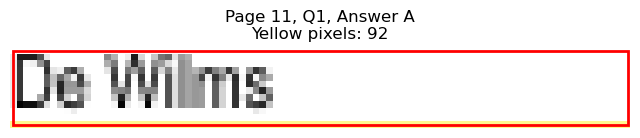

Page 11, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=143.5, y1=127.4
Page 11, Q1, B: Yellow pixels: 1062
Page 11, Q1, B: Total non-white pixels: 1512
Page 11, Q1, B: Yellow percentage: 70.2%


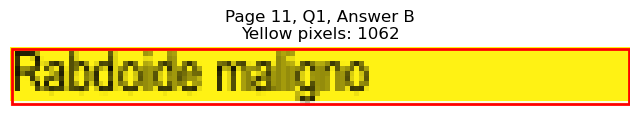

Page 11, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=472.9, y1=114.8
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 719
Page 11, Q1, C: Yellow percentage: 0.0%


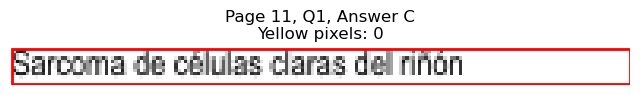

Page 11, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=461.3, y1=127.4
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 685
Page 11, Q1, D: Yellow percentage: 0.0%


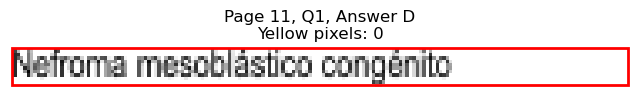


Page 11, Q1 - Selected Answer: B (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=126.0, y1=177.9
Page 11, Q2, A: Yellow pixels: 1082
Page 11, Q2, A: Total non-white pixels: 1296
Page 11, Q2, A: Yellow percentage: 83.5%


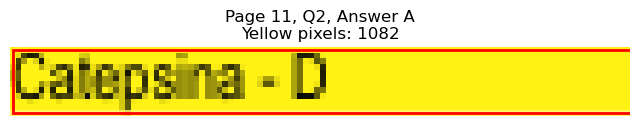

Page 11, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=111.4, y1=190.5
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 233
Page 11, Q2, B: Yellow percentage: 0.0%


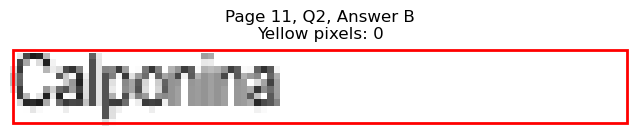

Page 11, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=377.6, y1=177.9
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 234
Page 11, Q2, C: Yellow percentage: 0.0%


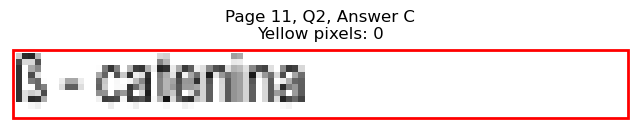

Page 11, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=355.6, y1=190.5
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 111
Page 11, Q2, D: Yellow percentage: 0.0%


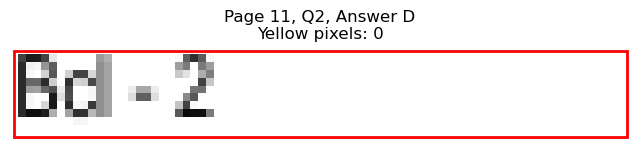


Page 11, Q2 - Selected Answer: A (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=111.4, y1=228.4
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 238
Page 11, Q3, A: Yellow percentage: 0.0%


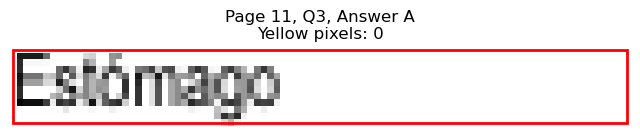

Page 11, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=94.3, y1=241.0
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 124
Page 11, Q3, B: Yellow percentage: 0.0%


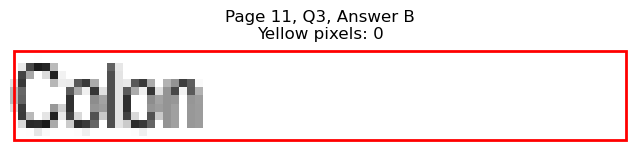

Page 11, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=372.1, y1=228.4
Page 11, Q3, C: Yellow pixels: 868
Page 11, Q3, C: Total non-white pixels: 1152
Page 11, Q3, C: Yellow percentage: 75.3%


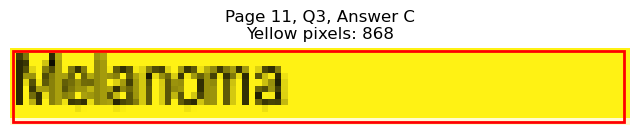

Page 11, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=373.1, y1=241.0
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 223
Page 11, Q3, D: Yellow percentage: 0.0%


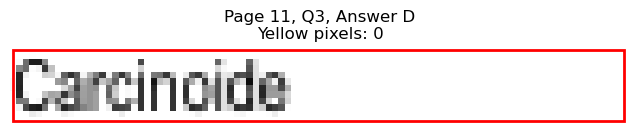


Page 11, Q3 - Selected Answer: C (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=68.3, y0=305.7, x1=170.0, y1=316.8
Page 11, Q4, A: Yellow pixels: 1427
Page 11, Q4, A: Total non-white pixels: 1836
Page 11, Q4, A: Yellow percentage: 77.7%


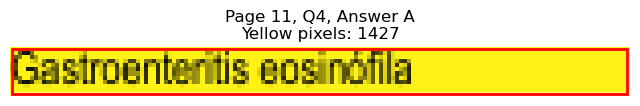

Page 11, Q4 - B: Detected box: x0=68.3, y0=318.3, x1=174.1, y1=329.4
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 512
Page 11, Q4, B: Yellow percentage: 0.0%


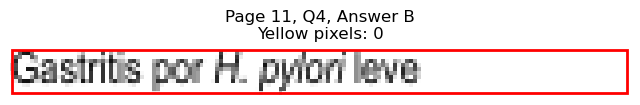

Page 11, Q4 - C: Detected box: x0=327.5, y0=305.7, x1=415.2, y1=316.8
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 476
Page 11, Q4, C: Yellow percentage: 0.0%


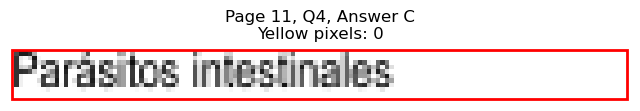

Page 11, Q4 - D: Detected box: x0=327.5, y0=318.3, x1=466.3, y1=329.4
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 716
Page 11, Q4, D: Yellow percentage: 0.0%


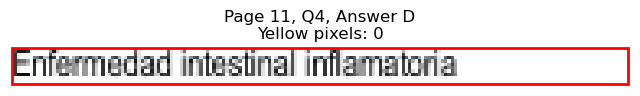


Page 11, Q4 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Mujer de 56 años con masa cervical tiroidea in...
1   ¿Qué cambios mamarios se presentan durante el ...
2   Las ...... en las válvulas cardiacas son la ma...
3   ¿Cuál es la neoplasia ósea benigna formada por...
4   Varón de 58 años con diarrea, baja de peso, ad...
..                                                ...
95  ¿En qué entidad podemos observar los microabsc...
96  ¿Cuál es el tumor renal pediátrico de alta mal...
97  ¿Cuál es la proteasa aspártica lisosómica sobr...
98  ¿Cuál es la neoplasia maligna metastásica más ...
99  Varón de 33 años con molestias gastrointestina...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                 De Riedel   
1     Aumento de la producción de estrógeno   
2   vegetaciones / endocarditis bacteriana.   
3                         Displasia fibrosa   
4                      Enfemedad de Whipple   
..                                      ...   
95          Dermatofibrosarcoma protuberans   
96                                 De Wilms   
97                            Catepsina - D   
98                                 Estómago   
99               Gastroenteritis eosinófila   

                               option_B  \
0     De Hashimoto, variante fibrosante   
1    Aumento de la densidad del estroma   
2   calcificaciones / fiebre reumática.   
3              Displasia cemento - ósea   
4                        Histoplasmosis   
..                                  ...   
95                         Mastocitosis   
96                     Rabdoide maligno   
97                            Calponina   
98                                Colon   
99         Gastritis por H. pylori leve   

                                          option_C  \
0                                         Subaguda   
1        Menor volumen mamario y contenido de agua   
2   células de Anichkov / endocarditis bacteriana.   
3                  Fibroma osificante psamomatoide   
4               Mycobacterium avium intracellulare   
..                                             ...   
95                                       Psoriasis   
96             Sarcoma de células claras del riñón   
97                                    ß - catenina   
98                                        Melanoma   
99                          Parásitos intestinales   

                                       option_D  
0                                   De Quervain  
1   Lobulillos mamarios relativamente inactivos  
2              vegetaciones / fiebre reumática.  
3                            Fibroma osificante  
4                             Macroglobulinemia  
..                                          ...  
95                             Micosis fungoide  
96               Nefroma mesoblástico congénito  
97                                      Bcl - 2  
98                                   Carcinoide  
99           Enfermedad intestinal inflamatoria  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               B
2               A
3               D
4               A
..            ...
95              D
96              B
97              A
98              C
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Mujer de 56 años con masa cervical tiroidea in...   
1   ¿Qué cambios mamarios se presentan durante el ...   
2   Las ...... en las válvulas cardiacas son la ma...   
3   ¿Cuál es la neoplasia ósea benigna formada por...   
4   Varón de 58 años con diarrea, baja de peso, ad...   
..                                                ...   
95  ¿En qué entidad podemos observar los microabsc...   
96  ¿Cuál es el tumor renal pediátrico de alta mal...   
97  ¿Cuál es la proteasa aspártica lisosómica sobr...   
98  ¿Cuál es la neoplasia maligna metastásica más ...   
99  Varón de 33 años con molestias gastrointestina...   

                                   option_A  \
0                                 De Riedel   
1     Aumento de la producción de estrógeno   
2   vegetaciones / endocarditis bacteriana.   
3                         Displasia fibrosa   
4                      Enfemedad de Whipple   
..                                      ...   
95          Dermatofibrosarcoma protuberans   
96                                 De Wilms   
97                            Catepsina - D   
98                                 Estómago   
99               Gastroenteritis eosinófila   

                               option_B  \
0     De Hashimoto, variante fibrosante   
1    Aumento de la densidad del estroma   
2   calcificaciones / fiebre reumática.   
3              Displasia cemento - ósea   
4                        Histoplasmosis   
..                                  ...   
95                         Mastocitosis   
96                     Rabdoide maligno   
97                            Calponina   
98                                Colon   
99         Gastritis por H. pylori leve   

                                          option_C  \
0                                         Subaguda   
1        Menor volumen mamario y contenido de agua   
2   células de Anichkov / endocarditis bacteriana.   
3                  Fibroma osificante psamomatoide   
4               Mycobacterium avium intracellulare   
..                                             ...   
95                                       Psoriasis   
96             Sarcoma de células claras del riñón   
97                                    ß - catenina   
98                                        Melanoma   
99                          Parásitos intestinales   

                                       option_D correct_answer  
0                                   De Quervain              A  
1   Lobulillos mamarios relativamente inactivos              B  
2              vegetaciones / fiebre reumática.              A  
3                            Fibroma osificante              D  
4                             Macroglobulinemia              A  
..                                          ...            ...  
95                             Micosis fungoide              D  
96               Nefroma mesoblástico congénito              B  
97                                      Bcl - 2              A  
98                                   Carcinoide              C  
99           Enfermedad intestinal inflamatoria              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/ANATOMIA PATOLOGICA.csv
